# **Project: London Energy Consumption Forecast Regression**
<hr>



I did the project on Colab, so I use the dataset that is downloaded from Kaggle directly.



# **Pre-processing**

## **Import the dependencies and packages.**

In [ ]:
import os
import sys
import shutil
os.environ["JAVA_HOME"] = '/Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home'
path = '/Users/aru/Desktop/1996005'

In [ ]:
kd_path = path + '/Kaggle_data' 
if os.path.exists(kd_path): 
  # Recursively delete directories. If the subdirectory is successfully deleted, the parent directory will be deleted successfully. 
  #If the subdirectory is not deleted successfully, an exception will be thrown.
  shutil.rmtree(kd_path)
else:
    print('no such file') 

k_path = path + '/energy.csv'
if os.path.exists(k_path): 
    os.remove(k_path)  

else:
    print('no such file') 

no such file
no such file


In [ ]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import seaborn as sns
import matplotlib.pyplot as plt 
from pyspark.sql.functions import date_format
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import datetime
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.stats.diagnostic import unitroot_adf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neural_network import MLPRegressor

ModuleNotFoundError: ignored

## **Read the dataset**

Read data from 112 different files and select desired column. 

In [ ]:
os.mkdir(path + '/Kaggle_data')

In [ ]:
for index in range(0,112):
    df = pd.read_csv(path+"/Kaggle/daily_dataset/daily_dataset/block_"+str(index)+".csv")
    df = df[['LCLid','day','energy_sum']]
    df.reset_index()
    df.reset_index()
    df.to_csv(path+"/Kaggle_data/new_data_"+str(index)+".csv")

## **Sort the CSV file and create a new DataFrame**

Create a new file and write these data into the file.

In [ ]:
fout= open("energy.csv","a")

In [ ]:
for line in open(path+"/Kaggle_data/new_data_0.csv"):
    fout.write(line)  
for index in range(0,112):
    f = open(path+"/Kaggle_data/new_data_"+str(index)+".csv")
    f.readline()
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [ ]:
df = pd.read_csv('energy.csv')

In [ ]:
df.count()

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df_weather = pd.read_csv(path+'/Kaggle/weather_daily_darksky.csv')
df_holiday = pd.read_csv(path+'/Kaggle/uk_bank_holidays.csv')

## **Combine and clean the Dataset**

I got a dataset that includes energy consumption per household per day. And I'll combine the data to show the sum of the energy consumption everyday. 

We can see there are 829 different days in the dataset, and the number of the household are different which was increased over time. So I change the total energy consumption into the average energy consumption to show the change of energy consumption over time.

In [ ]:
LCL_df = df.groupby('day')[['LCLid']].nunique()
print(LCL_df)

In [ ]:
energy_df = df.groupby('day')[['energy_sum']].sum()

In [ ]:
energy_df.info()

In [ ]:
LCL_df['energy_sum'] = energy_df['energy_sum']

In [ ]:
LCL_df.rename(columns={'LCLid':'house_num'}, inplace=True)
LCL_df = LCL_df.reset_index()
LCL_df.info()

In [ ]:
LCL_df['day'] = pd.to_datetime(LCL_df['day'],format='%Y/%m/%d').dt.date
LCL_df.day

In [ ]:
LCL_df.head()

In [ ]:
new_df = LCL_df

I also read the data about the bank holidays in UK which includes the date of bank holidays in this time period. And I'm going to combine this table into the last dataset as a feature, and if the day is a bank holiday in UK this record it as 1, otherwise, record it as 0.

In [ ]:
df_holiday['Bank holidays'] = pd.to_datetime(df_holiday['Bank holidays'],format='%Y/%m/%d').dt.date
df_holiday.rename(columns={'Bank holidays':'day'}, inplace=True)
df_holiday.info()

In [ ]:
new_df = pd.merge(new_df, df_holiday, on='day', how = 'left')
new_df['Type'].where(new_df['Type'].isnull(),1,inplace=True)
new_df['Type'] = new_df['Type'].fillna(0)
new_df.rename(columns={'Type':'is_holiday'}, inplace=True)
new_df

I read the weather data file into the code and combine them, to show daily weather in these 829 days. 

In [ ]:
df_weather['day'] = pd.to_datetime(df_weather['time'],format='%Y/%m/%d').dt.date

In [ ]:
new_df = pd.merge(new_df, df_weather, on='day')

In [ ]:
new_df.drop('time',axis=1,inplace=True)

In [ ]:
new_df['energy_avg'] = new_df['energy_sum'] / new_df['house_num']
new_df.drop('energy_sum', axis=1, inplace=True)
new_df.info()

In this step, we can see most data is not null, so we can keep 828 not null rows and do something else. 

In [ ]:
new_df = new_df.dropna(how='any')
new_df.info()

In next steps, I try to process the dataset by PySpark.

In [ ]:
# Create new spark session.
spark = SparkSession.builder.appName('Forecast').getOrCreate()
sdf = spark.createDataFrame(new_df)
sdf.count()

In [ ]:
sdf.show()

Convert time data in dataset to date format, and divide the date in every rows into separate year, month and day(Year just has three different value so I do not add it).

Convert the sunrise and sunset time into a hour value. Because the year, month and day value is same to other feature,so I just keep the hour as the sunrise and sunset time.

In [ ]:
sdfM = sdf.select(sdf['day'],date_format('day','MM').alias('month'), 
                  date_format('day','dd').alias('date'), 
                  date_format('sunriseTime','hh').alias('sunrise_hour'),
                  date_format('sunsetTime','hh').alias('sunset_hour')
                  )

In [ ]:
# After 'join', there are two columns having same name, so I have to drop one of them, otherwise I cannot operate the dataset.
sdf = sdf.join(sdfM,['day'],how='left').drop()
sdf = sdf.dropDuplicates()
sdf.count()

Some features in the dataset are similar, so I delete some of them.

In [ ]:
sdf = sdf.drop('temperatureMaxTime','temperatureMinTime','apparentTemperatureMinTime','apparentTemperatureHighTime','sunriseTime','sunsetTime','temperatureHighTime','uvIndexTime','temperatureLowTime','apparentTemperatureMaxTime','apparentTemperatureLowTime')


In [ ]:
sdf.show()

Then, I convert the pyspark df into pd df to process the text data feature in the dataset.

In [ ]:
pddf = sdf.to_pandas_on_spark()
pddf.isnull().sum()

In [ ]:
# Show how many different values there is and replace them by numbers.
pddf_icon = pddf.groupby('icon')[['house_num']].nunique()
pddf_icon.reset_index()
pddf_icon

In [ ]:
pddf['icon'] = pddf['icon'].replace('partly-cloudy-day',0)
pddf['icon'] = pddf['icon'].replace('fog',1)
pddf['icon'] = pddf['icon'].replace('clear-day',2)
pddf['icon'] = pddf['icon'].replace('cloudy',3)
pddf['icon'] = pddf['icon'].replace('wind',4)
pddf['icon'] = pddf['icon'].replace('partly-cloudy-night',5)
pddf.head()

In [ ]:
# This feature is really complex and too many unique values, while it is too detailed weather conditions, not very helpful for forecasting, so I drop it.
pddf_icon = pddf.groupby('summary')[['house_num']].nunique()
pddf_icon.reset_index()
pddf_icon

In [ ]:
pddf = pddf.drop('summary',axis=1)
pddf.head()

In [ ]:
pddf_icon = pddf.groupby('precipType')[['house_num']].nunique()
pddf_icon.reset_index()
pddf_icon

In [ ]:
pddf['precipType'] = pddf['precipType'].replace('rain',0)
pddf['precipType'] = pddf['precipType'].replace('snow',1)
pddf.head()

# **Feature analysis**

In [ ]:
pddf.sort_values('day',inplace=True)

In [ ]:
pddf.head()

22/06/07 01:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


day  house_num  is_holiday  temperatureMax  windBearing icon  dewPoint  cloudCover  windSpeed  pressure  apparentTemperatureHigh precipType  visibility  humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  energy_avg month date sunrise_hour sunset_hour
49  2011-11-23         13           0           10.36          229    1      6.29        0.36       2.04   1027.12                    10.36          0        8.06      0.93                    6.56                   10.36      1.0            8.24            3.81            10.36                    2.18       0.94    6.952692    11   23           07          04
29  2011-11-24         25           0           12.93          204    5      8.56        0.41       4.04   1027.22                    12.93          0       10.64      0.89                    7.30                   12.93      1.0            9.71            8.56            12.93                    7.01       0.97    8.536480    11   24           07          04
93  2011-11-25         32           0           13.03          243    0      7.24        0.48       5.02   1024.47                    12.27          0       12.38      0.79                    4.69                   13.03      1.0            7.01            7.46            12.27                    4.84       0.01    9.499781    11   25           07          04
20  2011-11-26         41           0           12.96          237    4      6.96        0.44       5.75   1025.80                    12.96          0       13.07      0.81                   11.59                   12.96      1.0           11.59            7.01            12.96                    4.69       0.05   10.267707    11   26           07          04
10  2011-11-27         41           0           13.54          256    4      5.76        0.42       5.48   1021.11                    13.54          0       13.08      0.72                    1.31                   13.54      1.0            1.31            4.47            13.54                    2.94       0.08   10.850805    11   27           07          04

For continuous data, I use plots to display the data. While as discrete values, I use the hist diagrams to show.

## **Data in Plot**

First I just show the data in these days and plot the mean and median of the data. Then I put the energy consumption and each feature on a graph to show the relationship between the feature and the energy consumption.

In [ ]:
pddf.info()

22/06/07 01:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 828 entries, 49 to 732
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   day                      828 non-null    object 
 1   house_num                828 non-null    int64  
 2   is_holiday               828 non-null    int64  
 3   temperatureMax           828 non-null    float64
 4   windBearing              828 non-null    int64  
 5   icon                     828 non-null    object 
 6   dewPoint                 828 non-null    float64
 7   cloudCover               828 non-null    float64
 8   windSpeed                828 non-null    float64
 9   pressure                 828 non-null    float64
 10  apparentTemperatureHigh  828 non-null    float64
 11  precipType               828 non-null    object 
 12  visibility               828 non-null    float64
 13  humidity                 828 non-null    float64
 14  apparentTemperatureLow

In [ ]:
continuous_data = ['house_num','temperatureMax','windBearing','dewPoint','cloudCover','windSpeed','pressure','apparentTemperatureHigh','visibility','humidity','apparentTemperatureLow','apparentTemperatureMax','uvIndex','temperatureLow','temperatureMin','temperatureHigh','apparentTemperatureMin','energy_avg']
date_data = ['month','date','sunrise_hour','sunset_hour']

In [ ]:
plt.close()

22/06/07 01:39:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:39:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


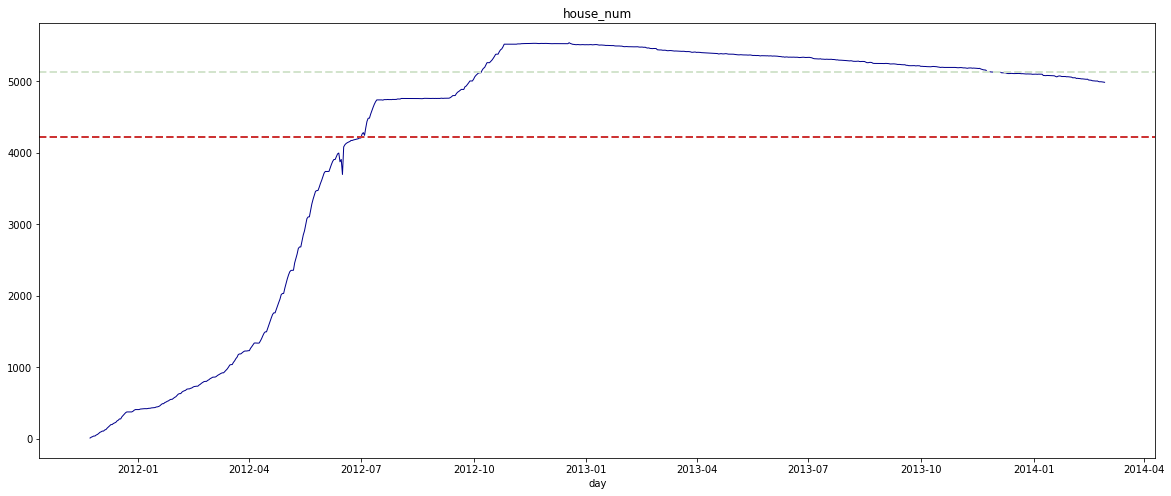

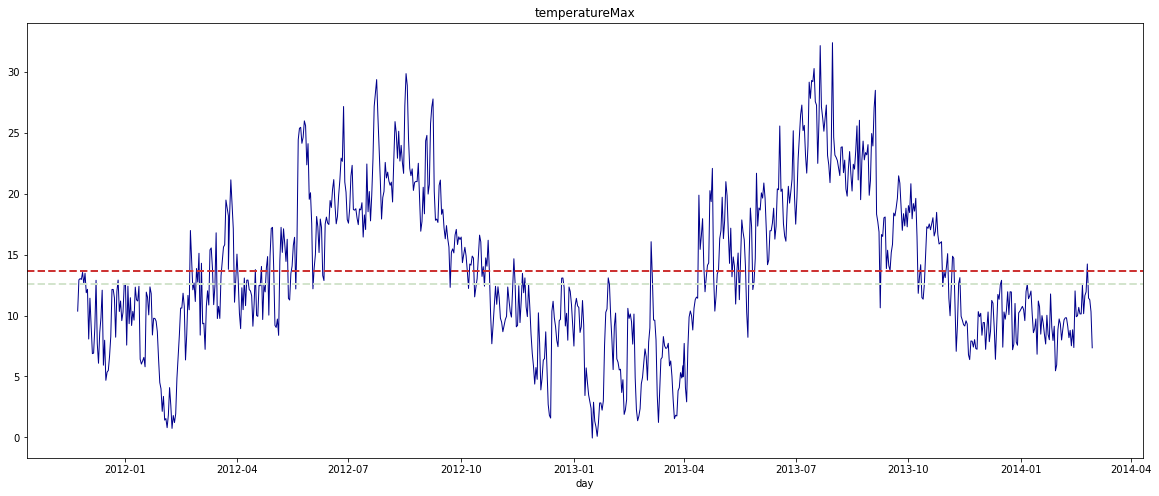

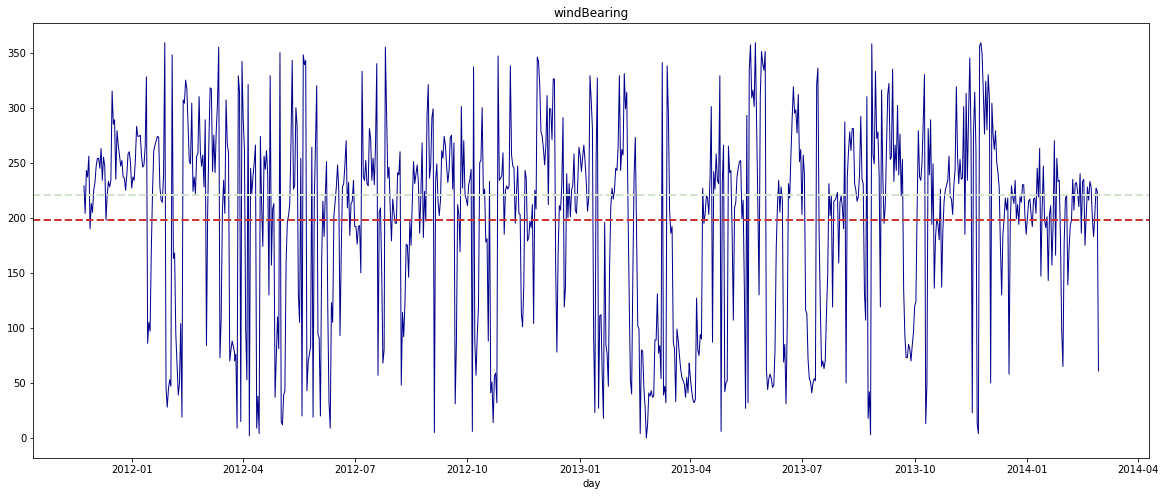

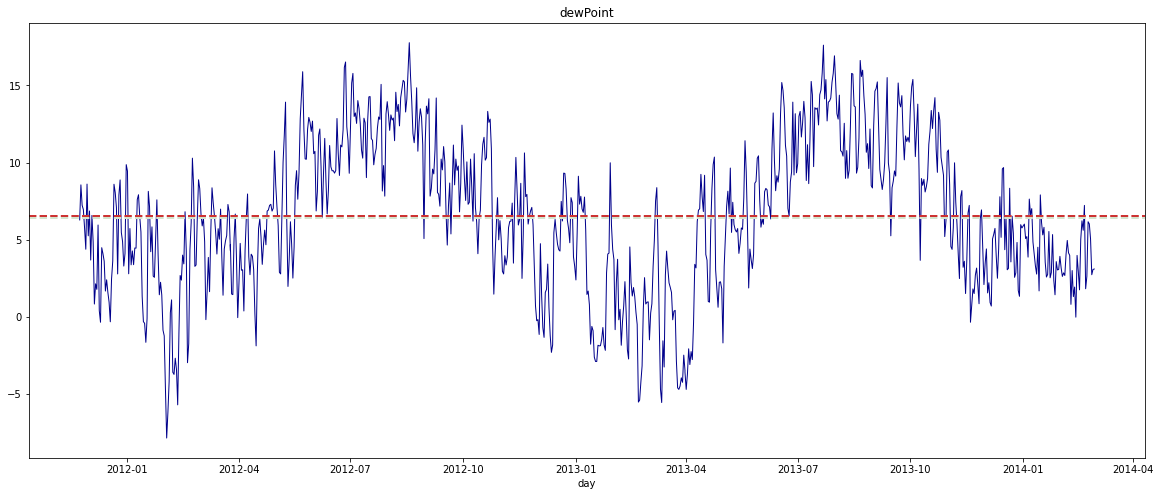

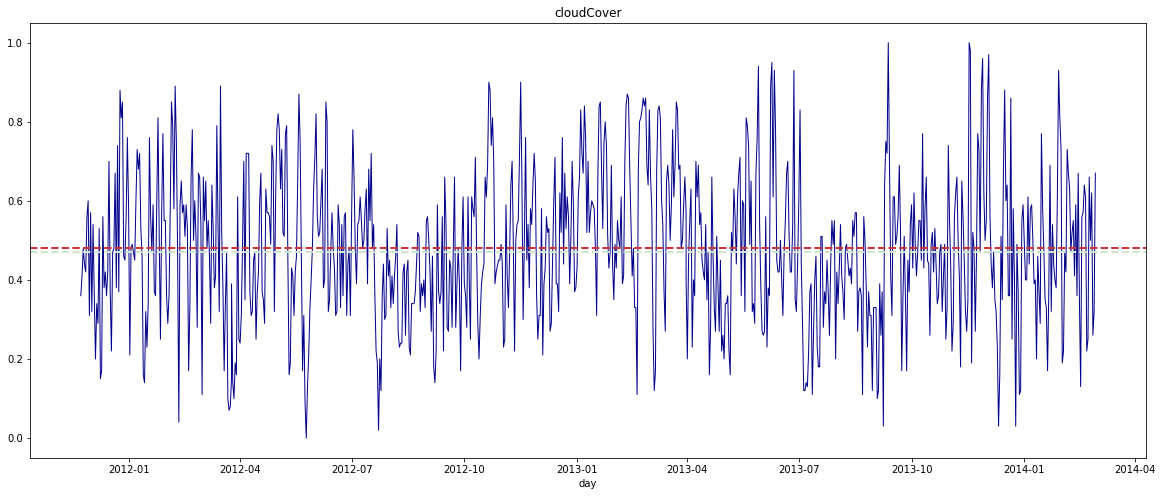

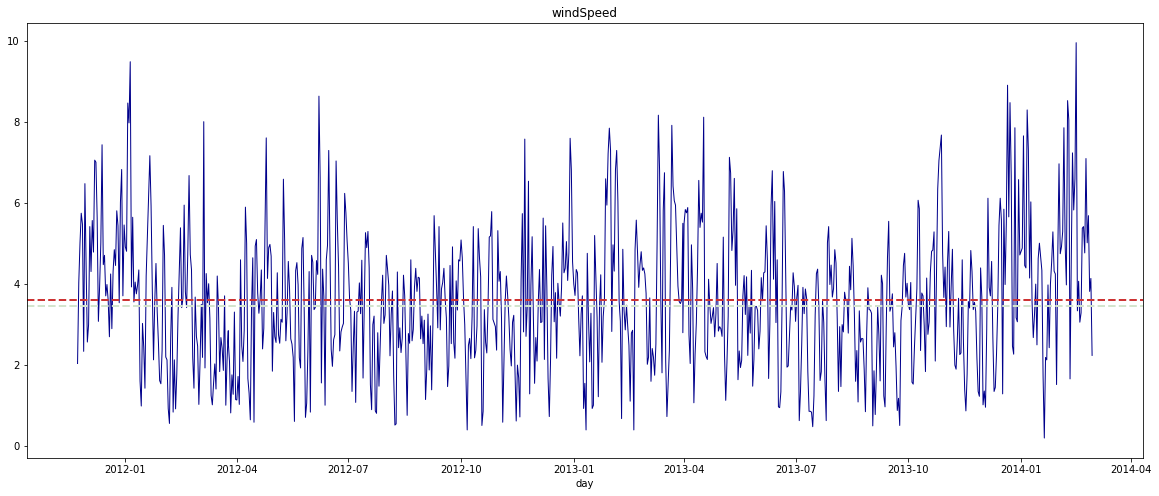

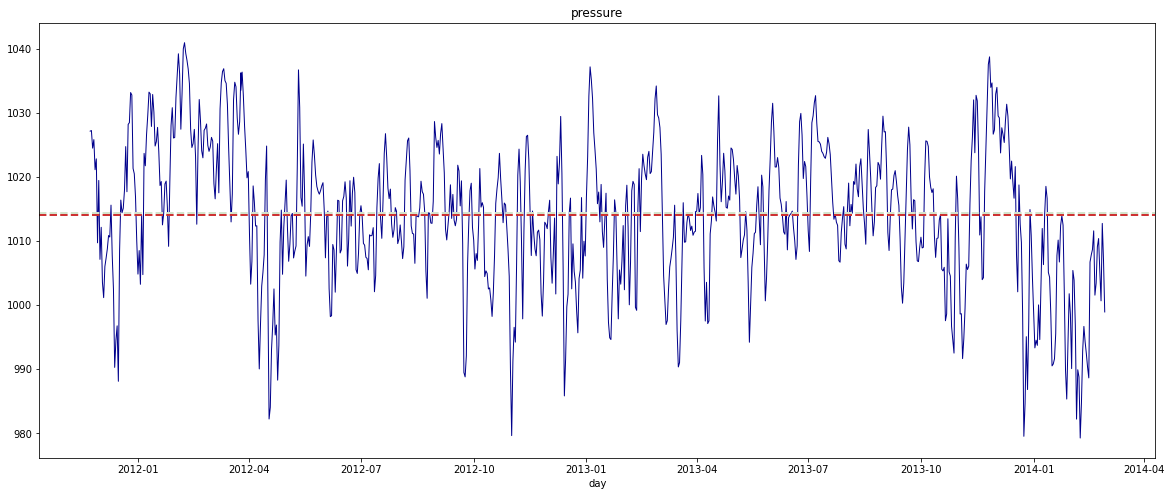

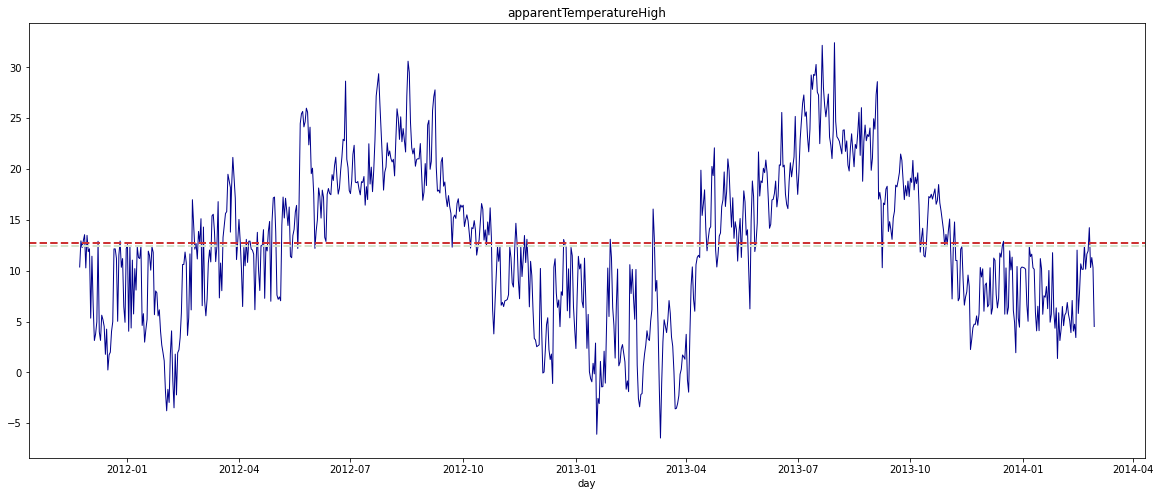

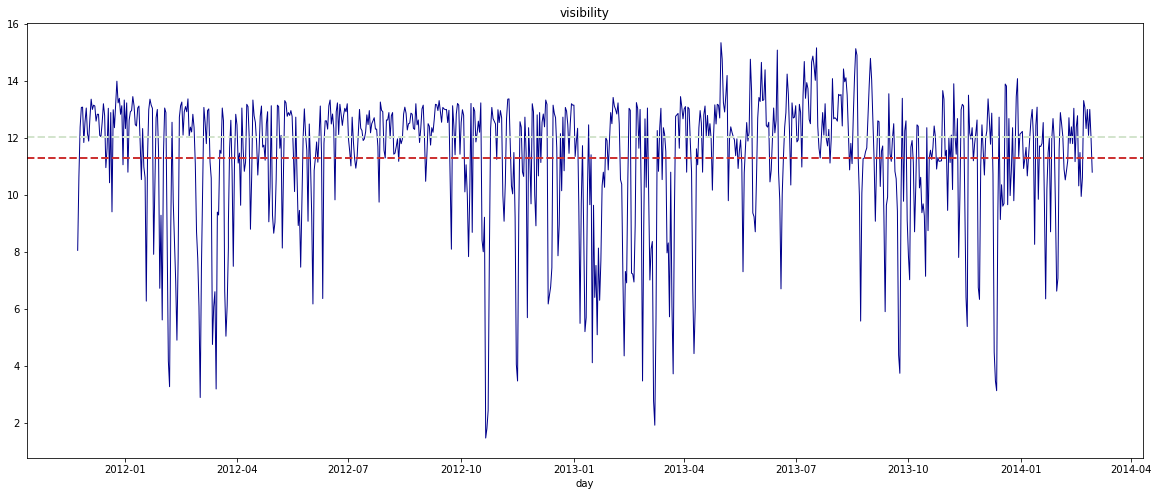

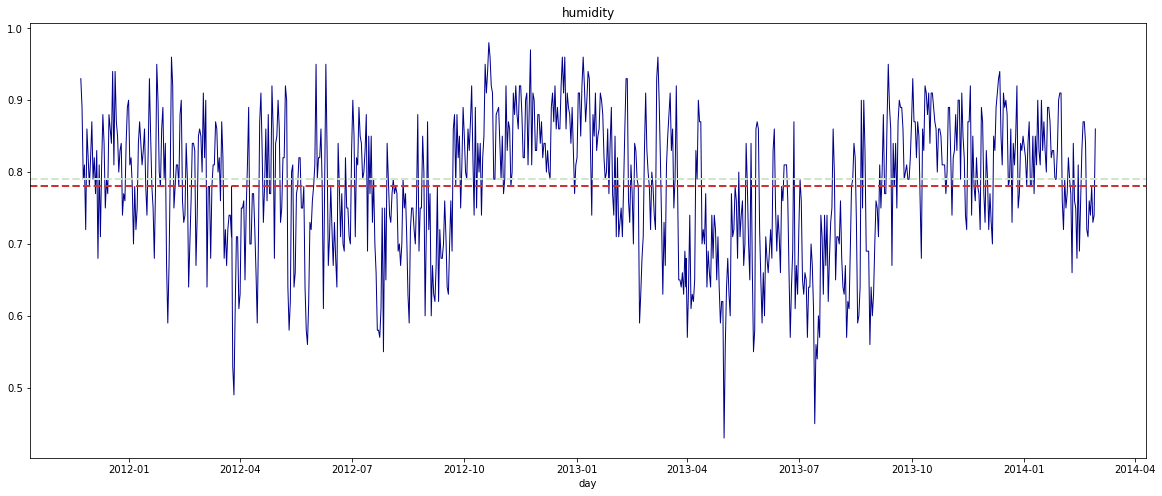

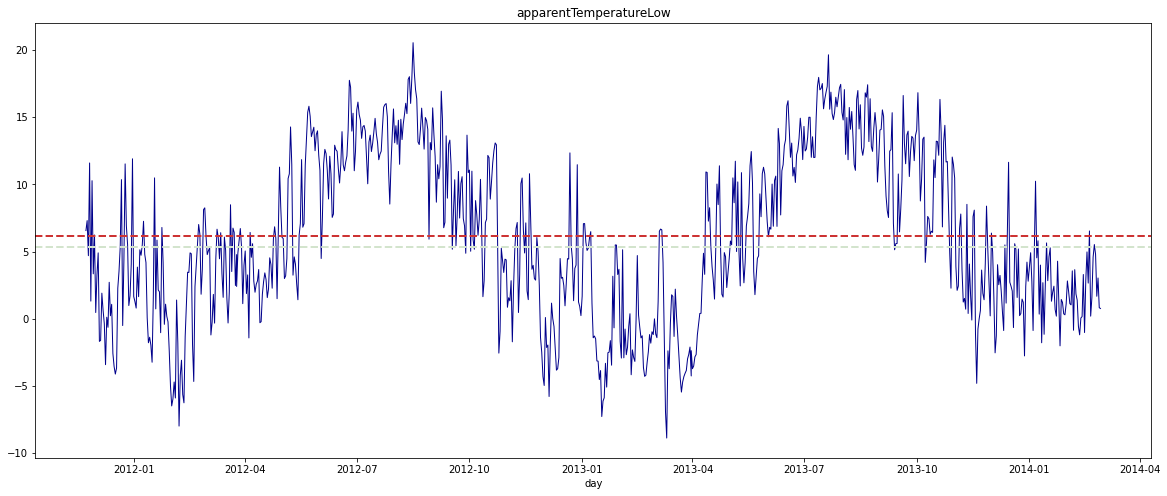

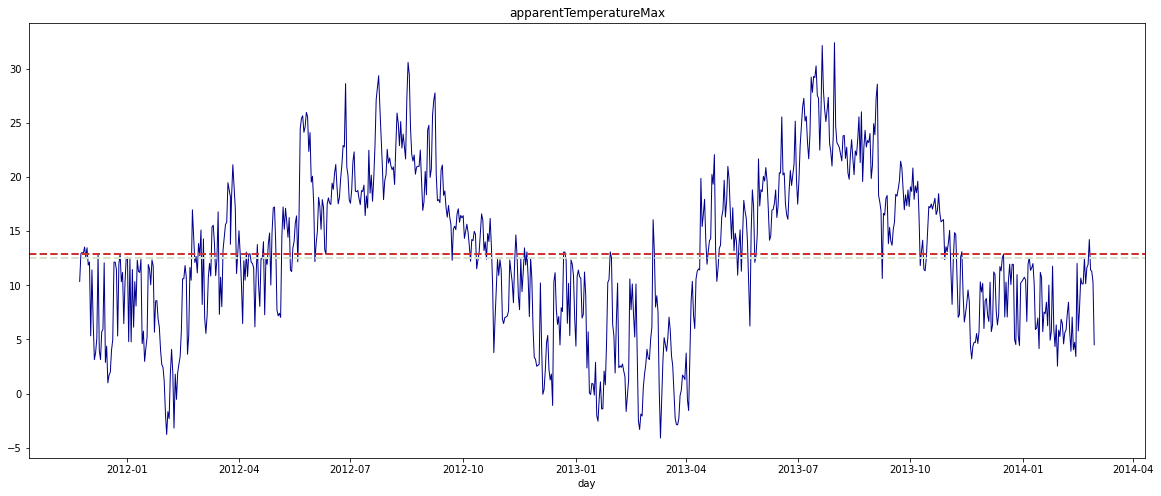

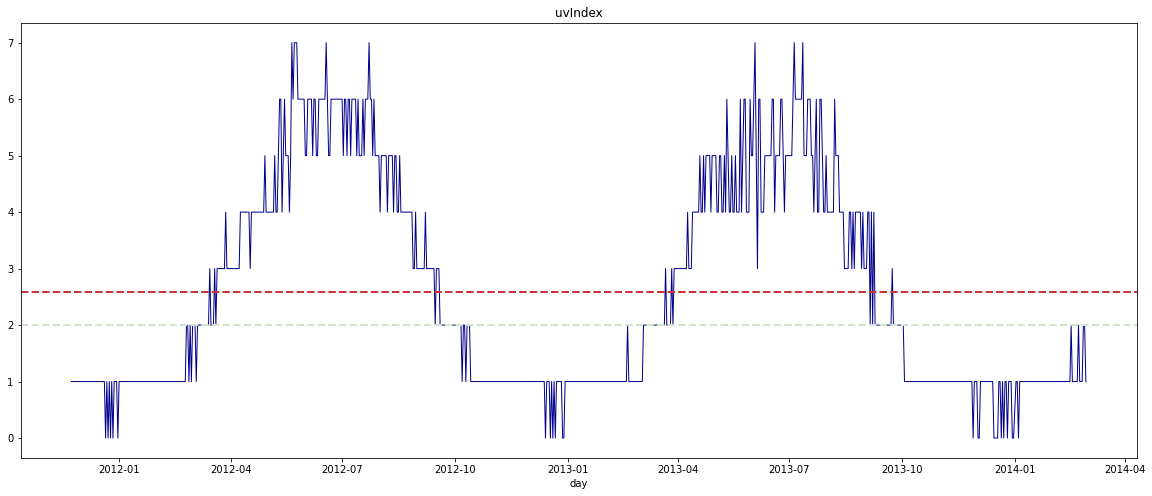

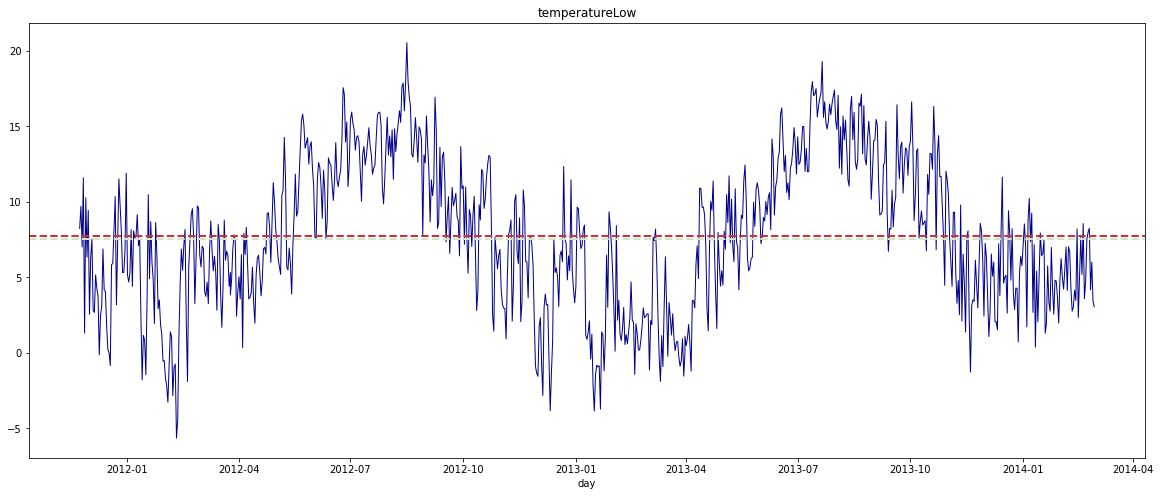

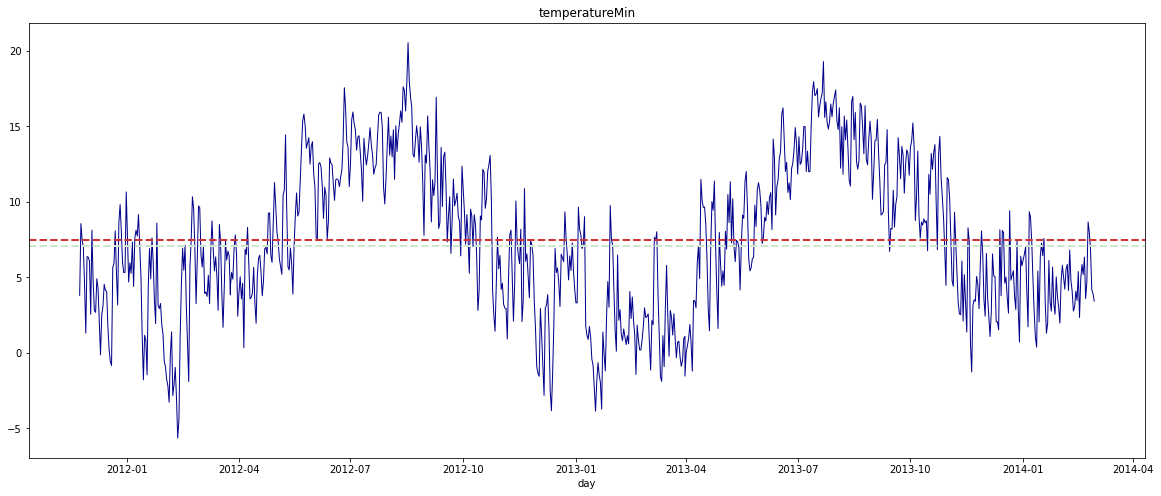

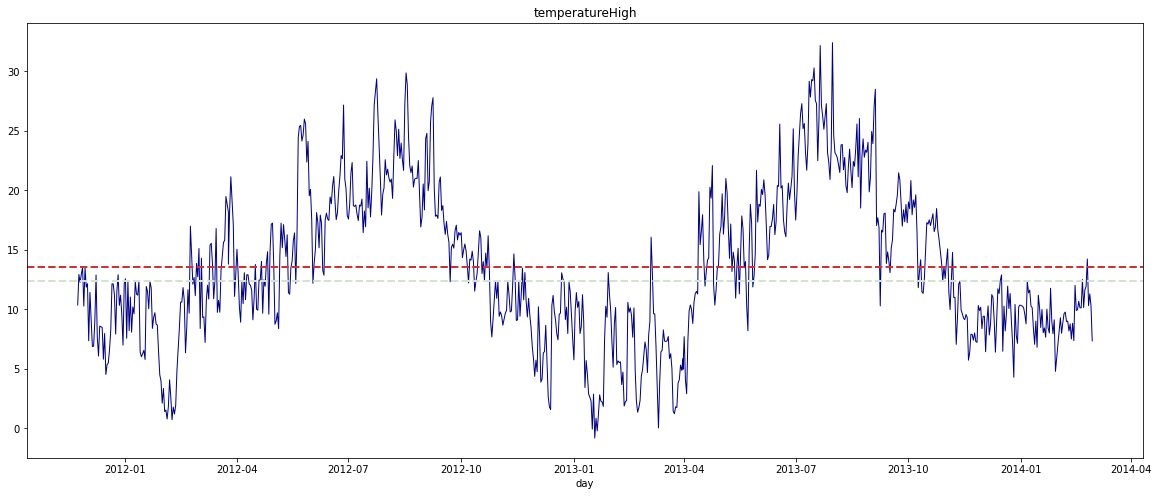

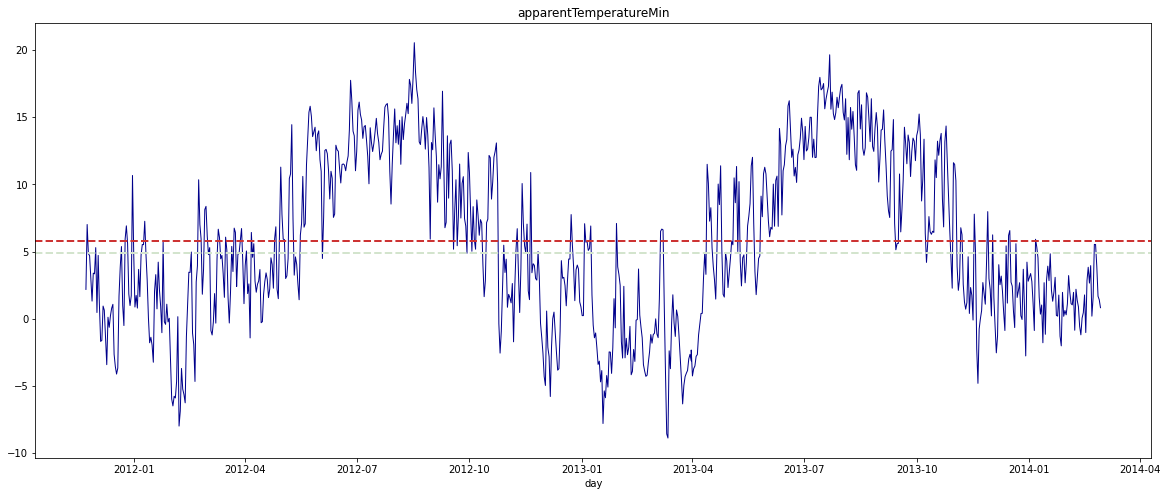

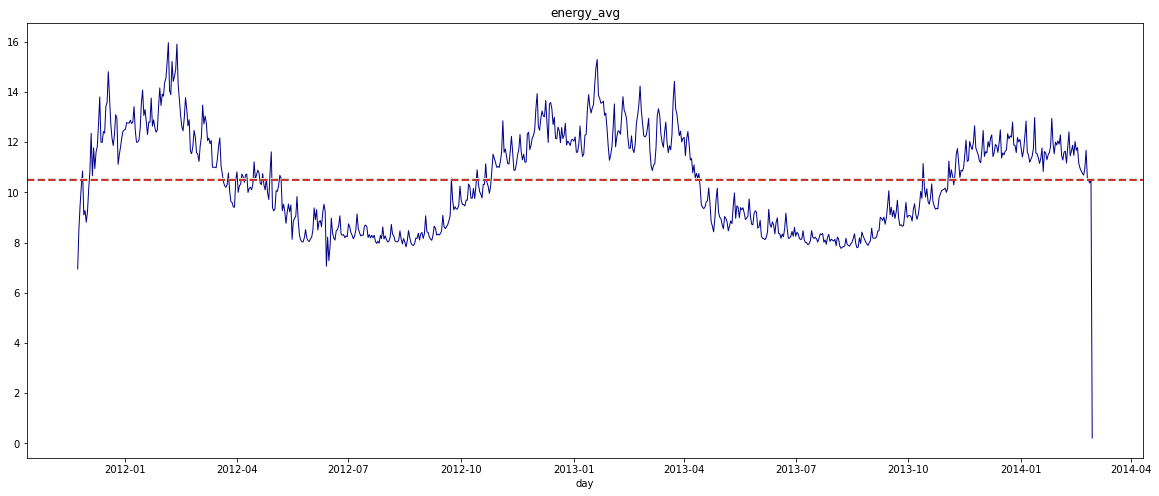

In [ ]:
for index in continuous_data:
  mid=pddf[index].median()
  mean=pddf[index].mean()
  # std=pddf[index].std()
  # print("the standard deviation of house_num is",std)

  plt.figure(figsize=(20,8))
  plt.plot(pddf['day'].to_numpy(),pddf[index].to_numpy(),color='#00008B',lw=1)

  plt.axhline(mid,c='#D3E4CD',ls='--',lw=2,label='Mid')
  plt.axhline(mean,c='#CD3333',ls='--',lw=2,label='Mean')

  plt.xlabel("day")
  plt.title(str(index))

  plt.show()
  plt.close()

In [ ]:
pddf[date_data] = pddf[date_data].astype('float64')

22/06/07 01:40:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


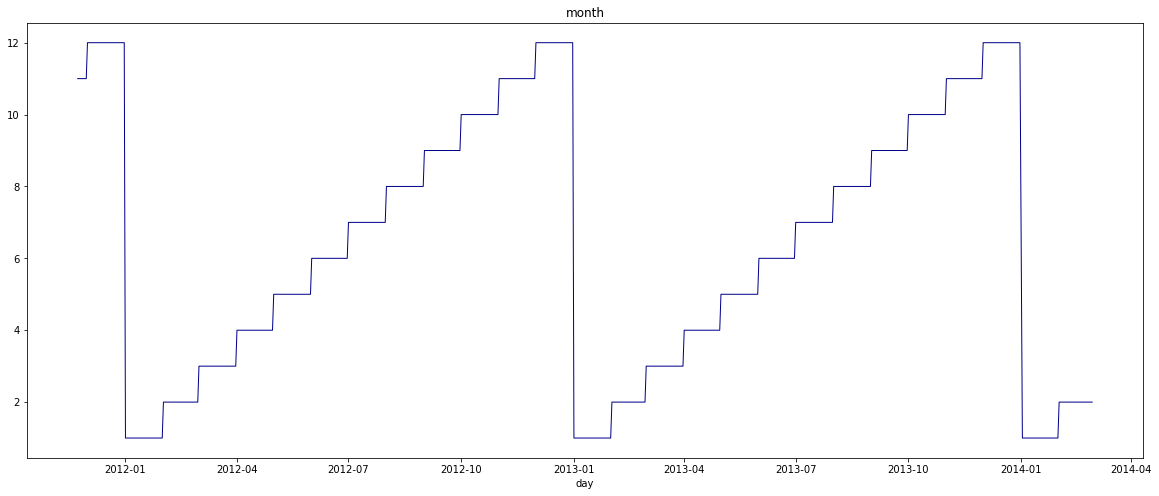

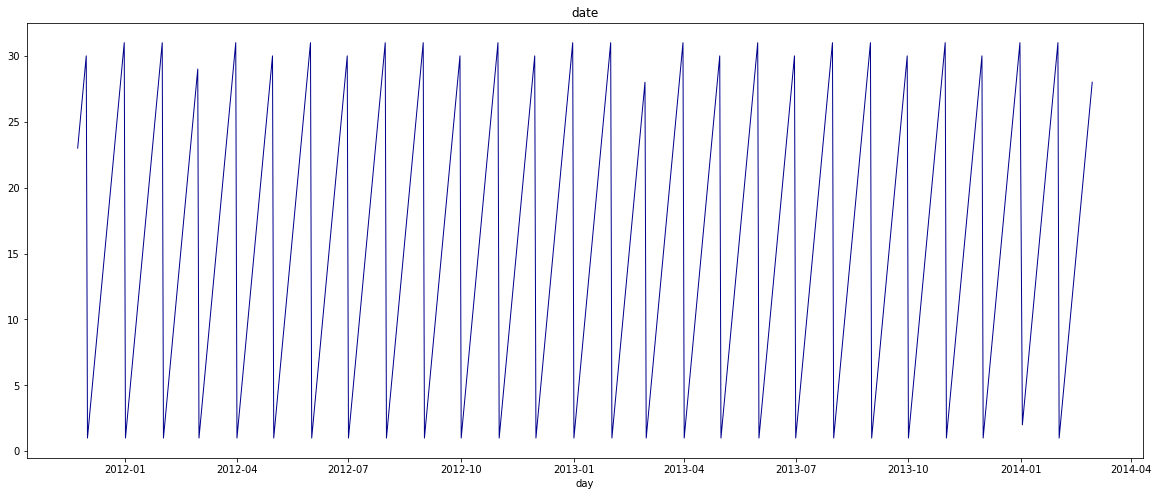

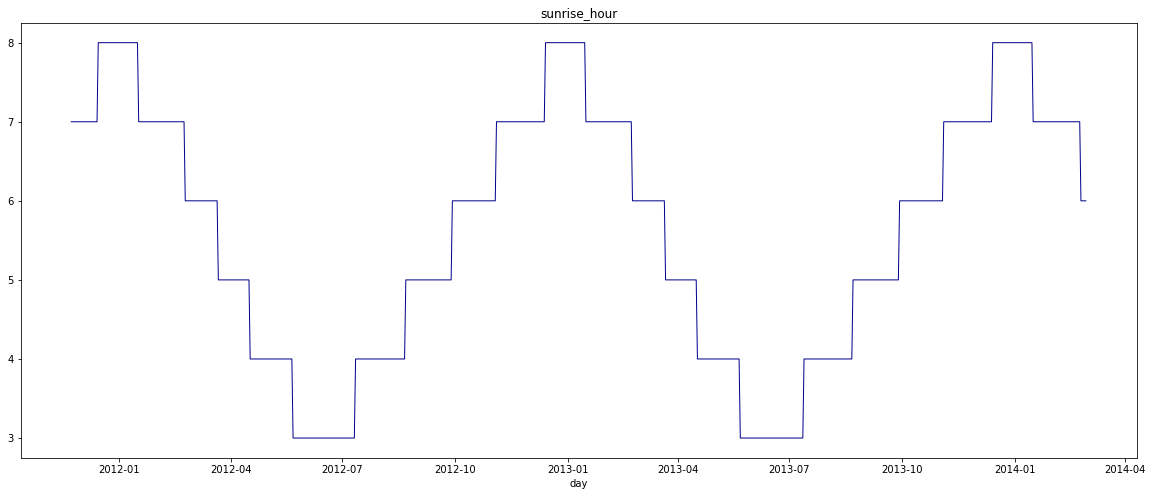

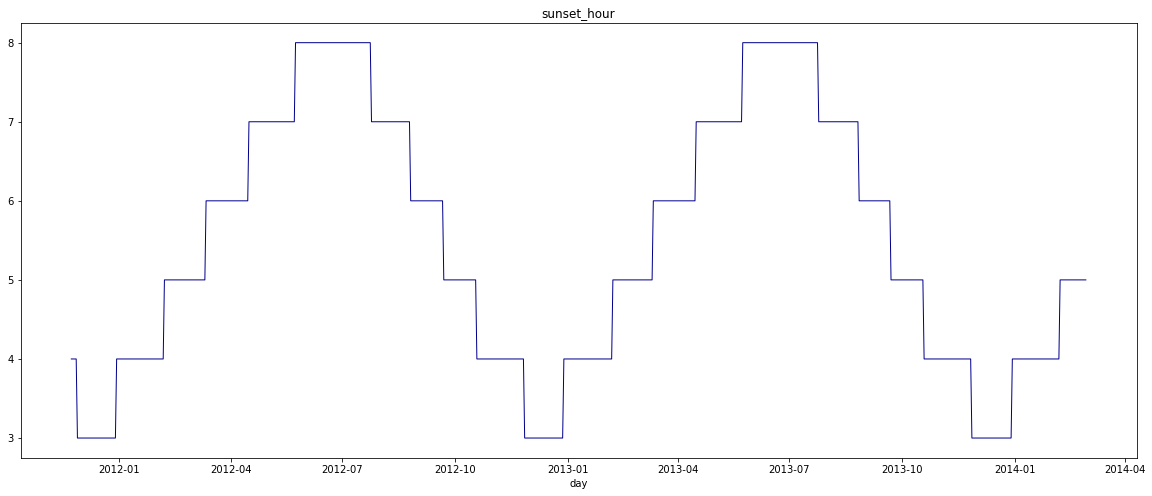

In [ ]:
for index in date_data:

  plt.figure(figsize=(20,8))
  plt.plot(pddf['day'].to_numpy(),pddf[index].to_numpy(),color='#00008B',lw=1)

  plt.xlabel("day")
  plt.title(str(index))

  plt.show()
  plt.close()

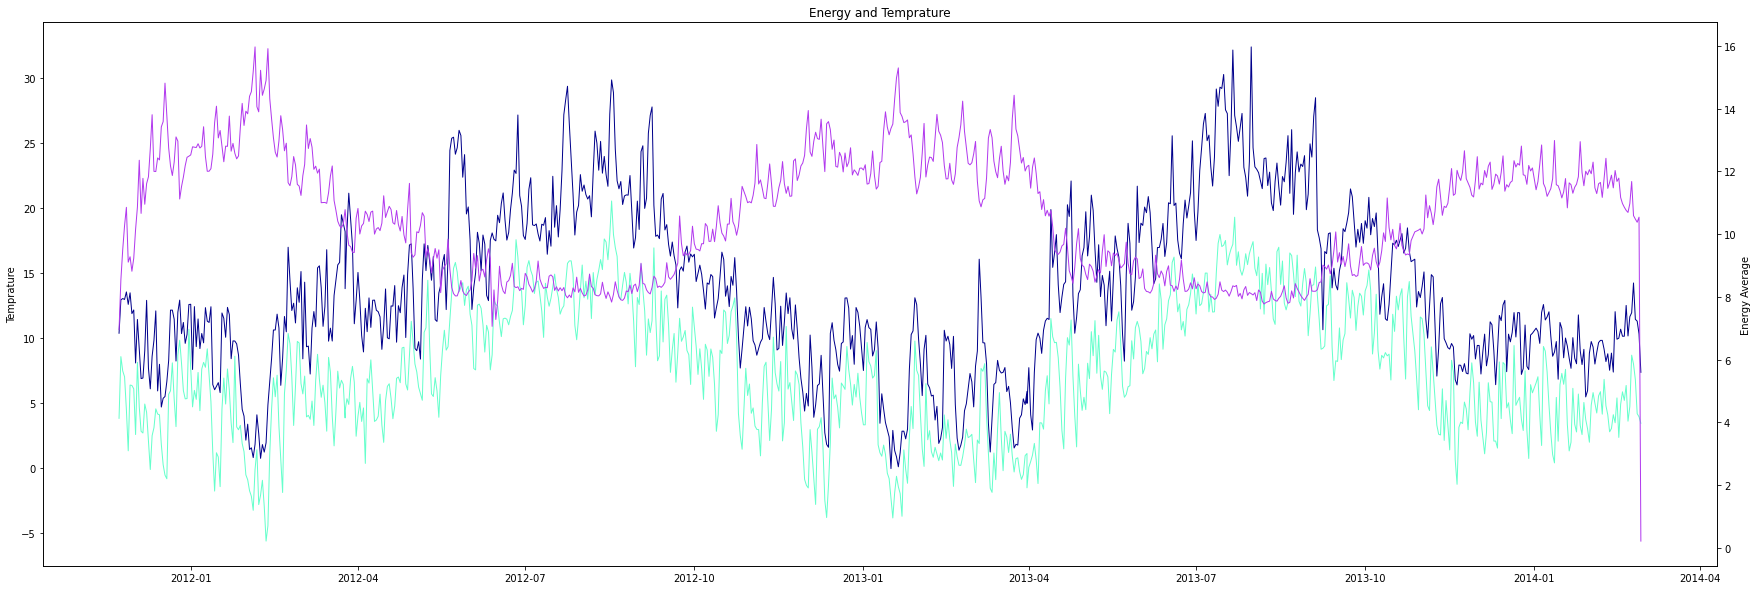

In [ ]:
fig,fig1 = plt.subplots(figsize=(30,10))
  
fig1.plot(pddf['day'].to_numpy(),pddf['temperatureMax'].to_numpy(),color='#00008B',lw=1)
fig1.plot(pddf['day'].to_numpy(),pddf['temperatureMin'].to_numpy(),color='#66ffcc',lw=1)
fig1.set_ylabel('Temprature')

fig2 = fig1.twinx()
fig2.plot(pddf['day'].to_numpy(),pddf['energy_avg'].to_numpy(),color='#B23AEE',lw=1)
fig2.set_ylabel('Energy Average')
plt.title('Energy and Temprature')
plt.show()
plt.close()

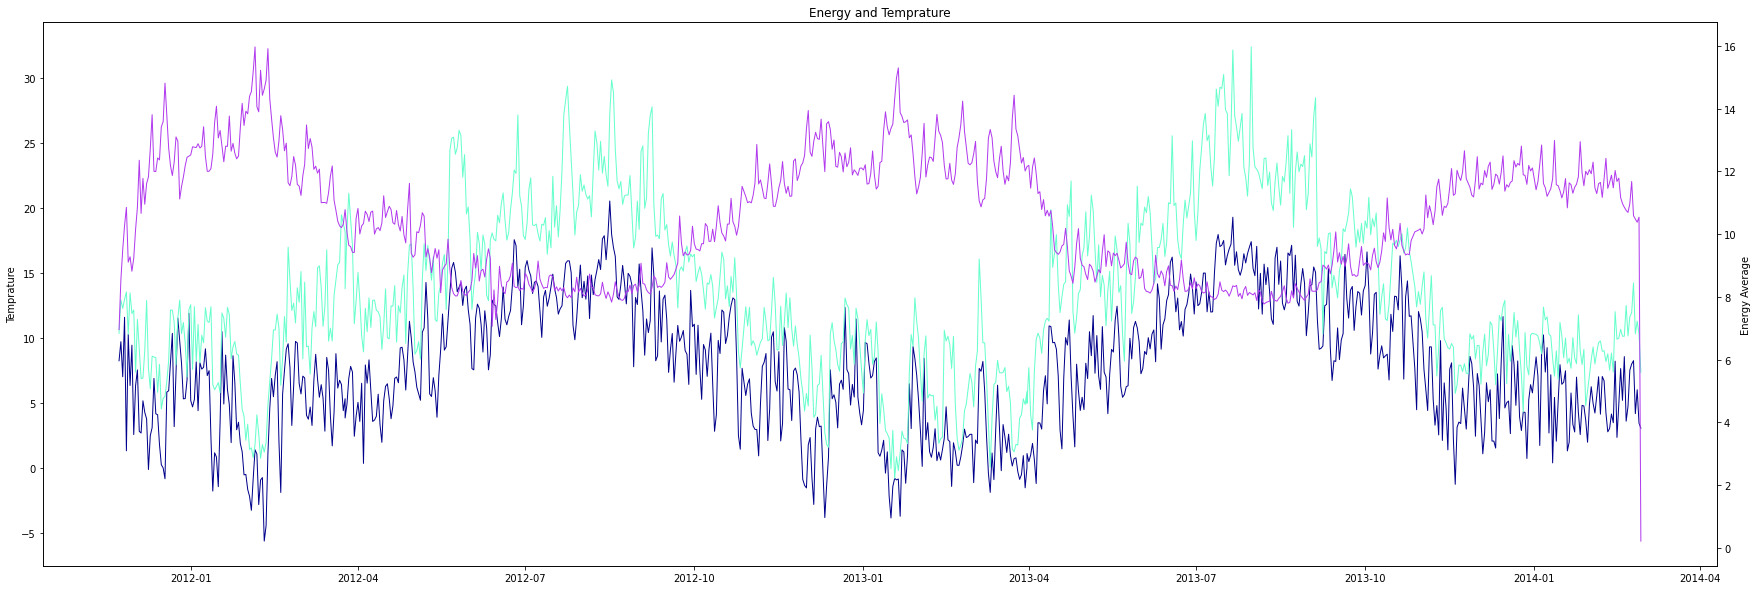

In [ ]:
fig,fig1 = plt.subplots(figsize=(30,10))
  
fig1.plot(pddf['day'].to_numpy(),pddf['temperatureLow'].to_numpy(),color='#00008B',lw=1)
fig1.plot(pddf['day'].to_numpy(),pddf['temperatureHigh'].to_numpy(),color='#66ffcc',lw=1)
fig1.set_ylabel('Temprature')

fig2 = fig1.twinx()
fig2.plot(pddf['day'].to_numpy(),pddf['energy_avg'].to_numpy(),color='#B23AEE',lw=1)
fig2.set_ylabel('Energy Average')
plt.title('Energy and Temprature')
plt.show()
plt.close()

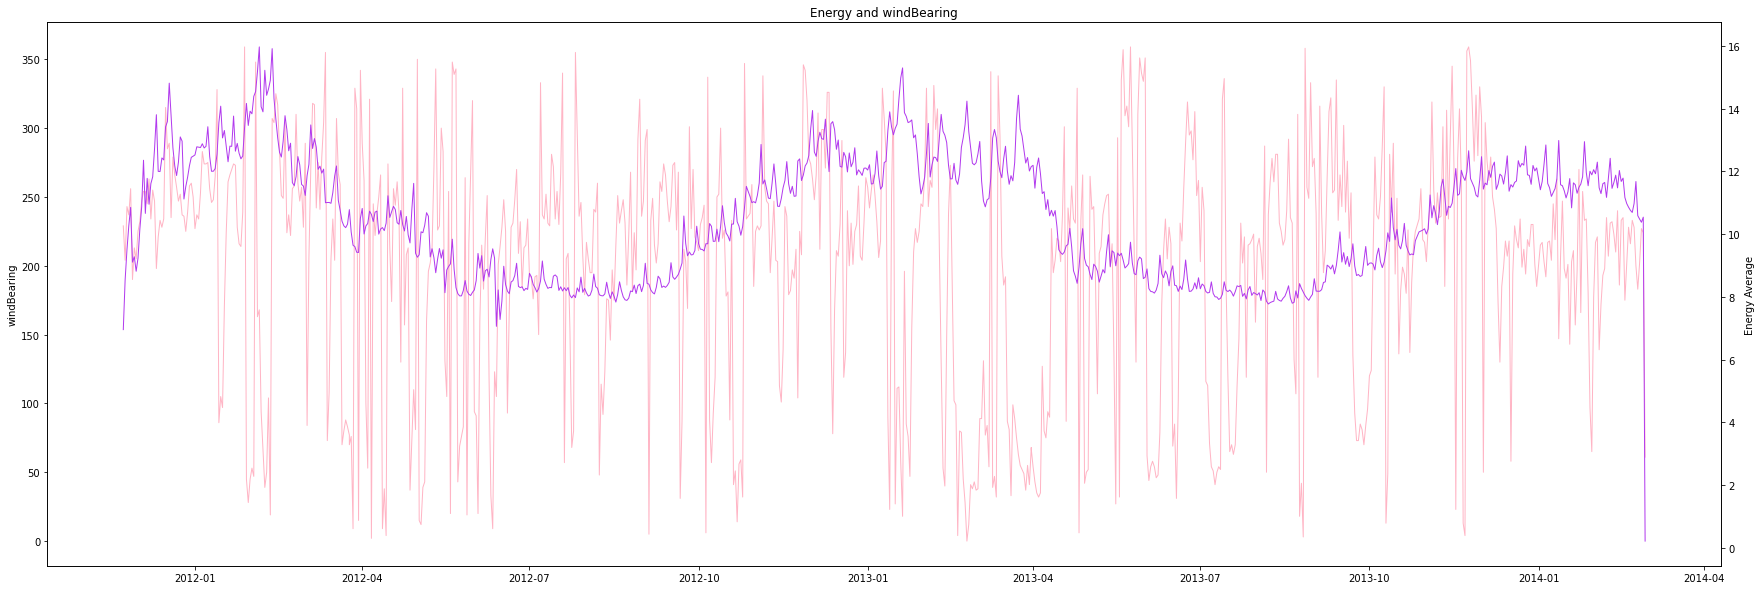

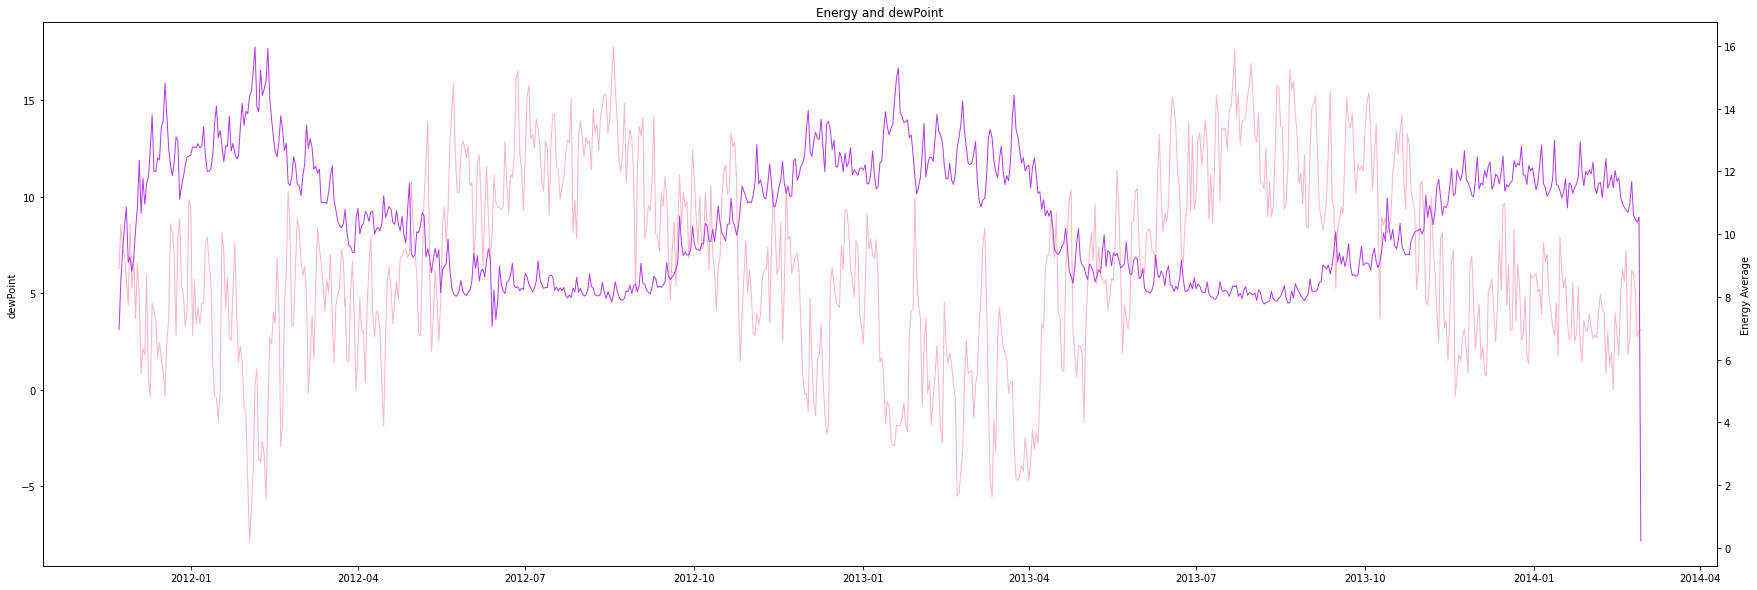

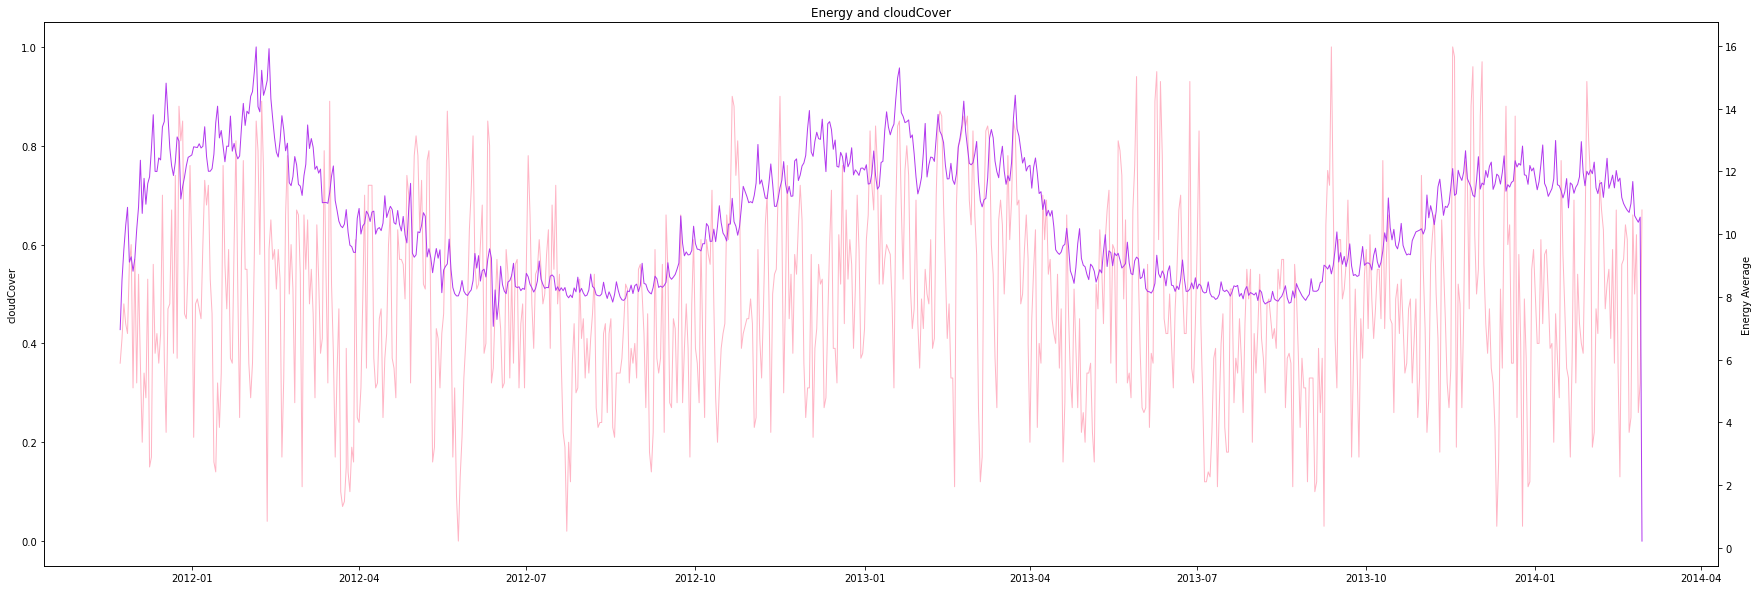

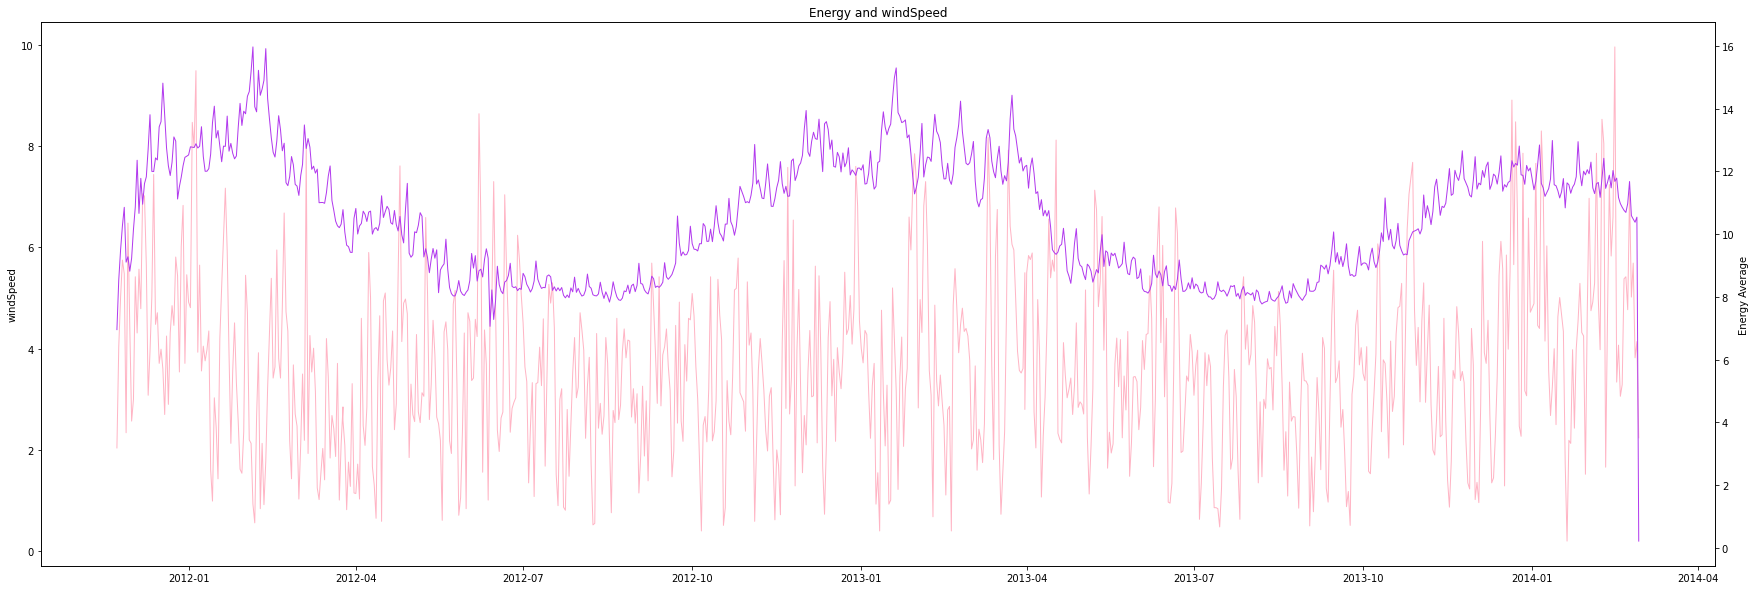

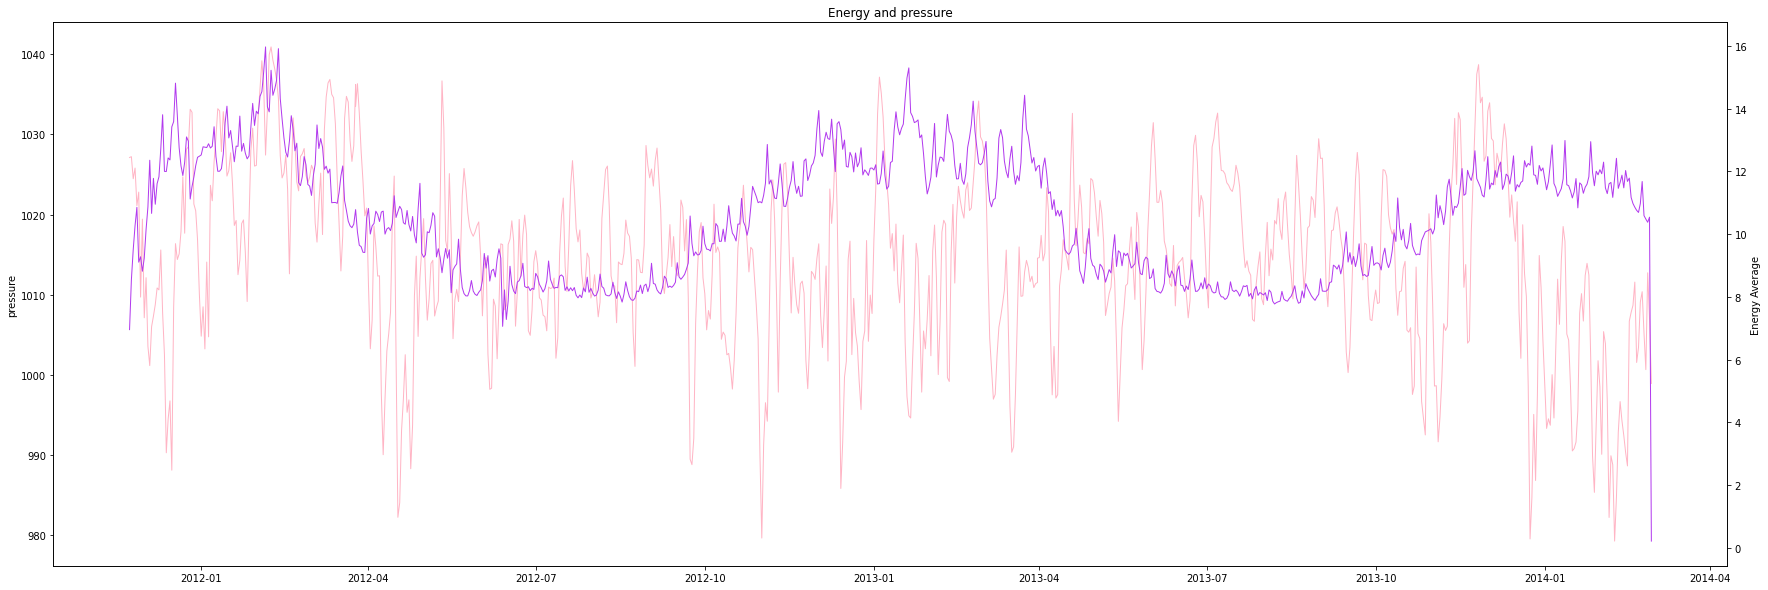

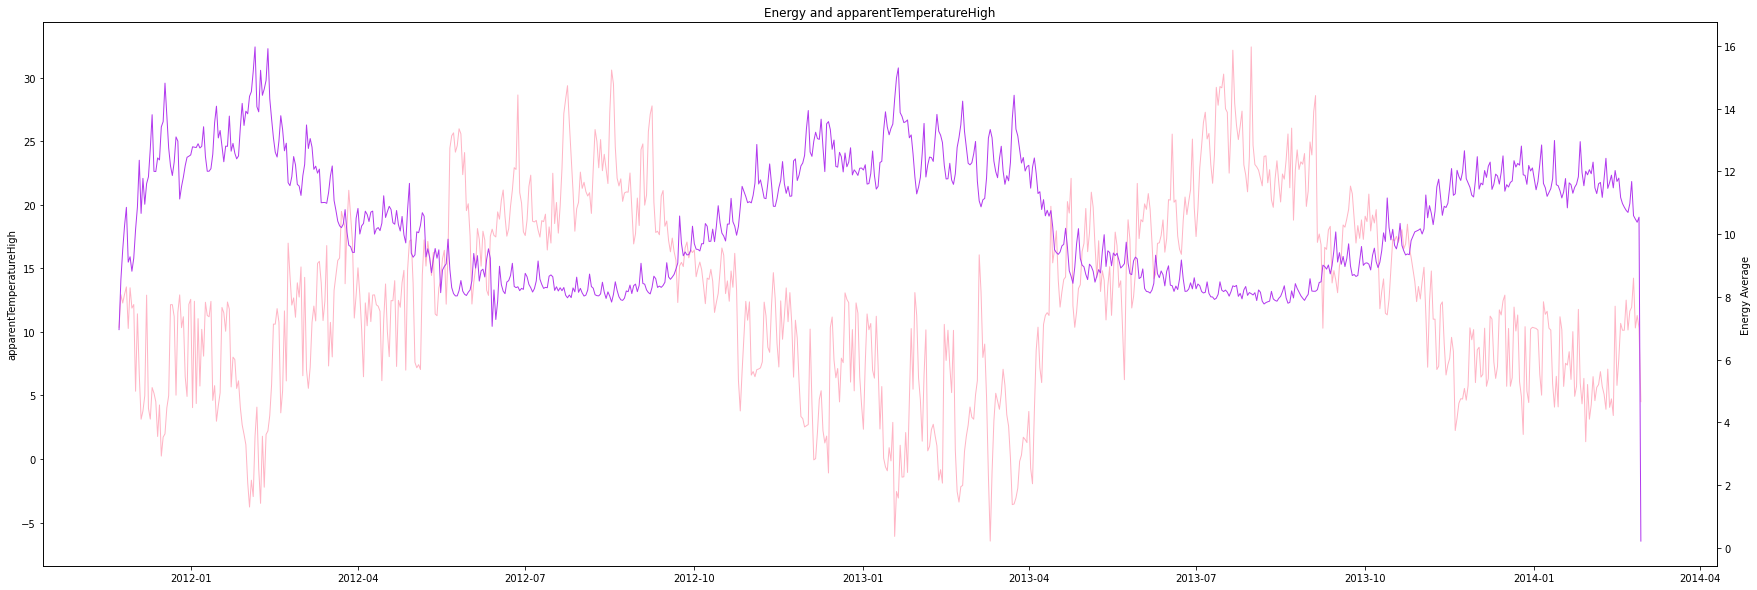

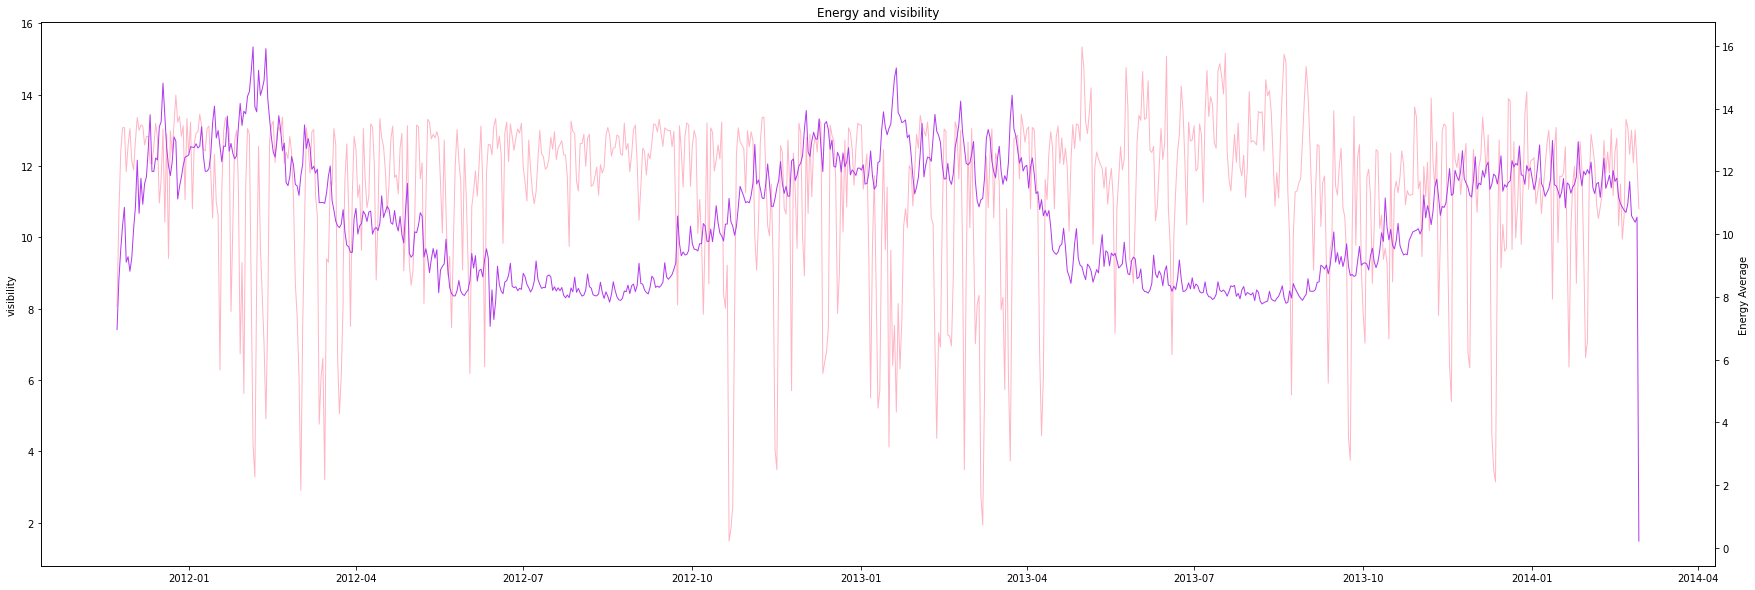

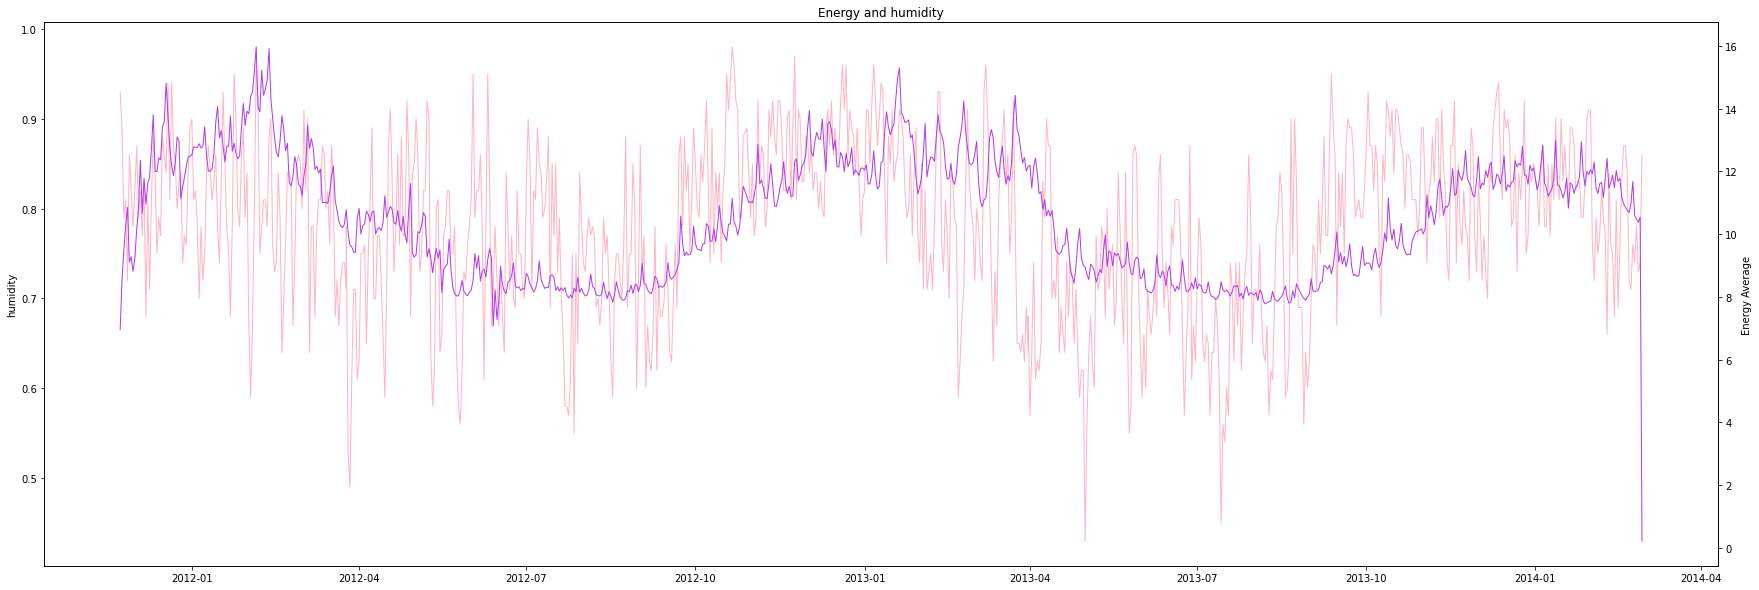

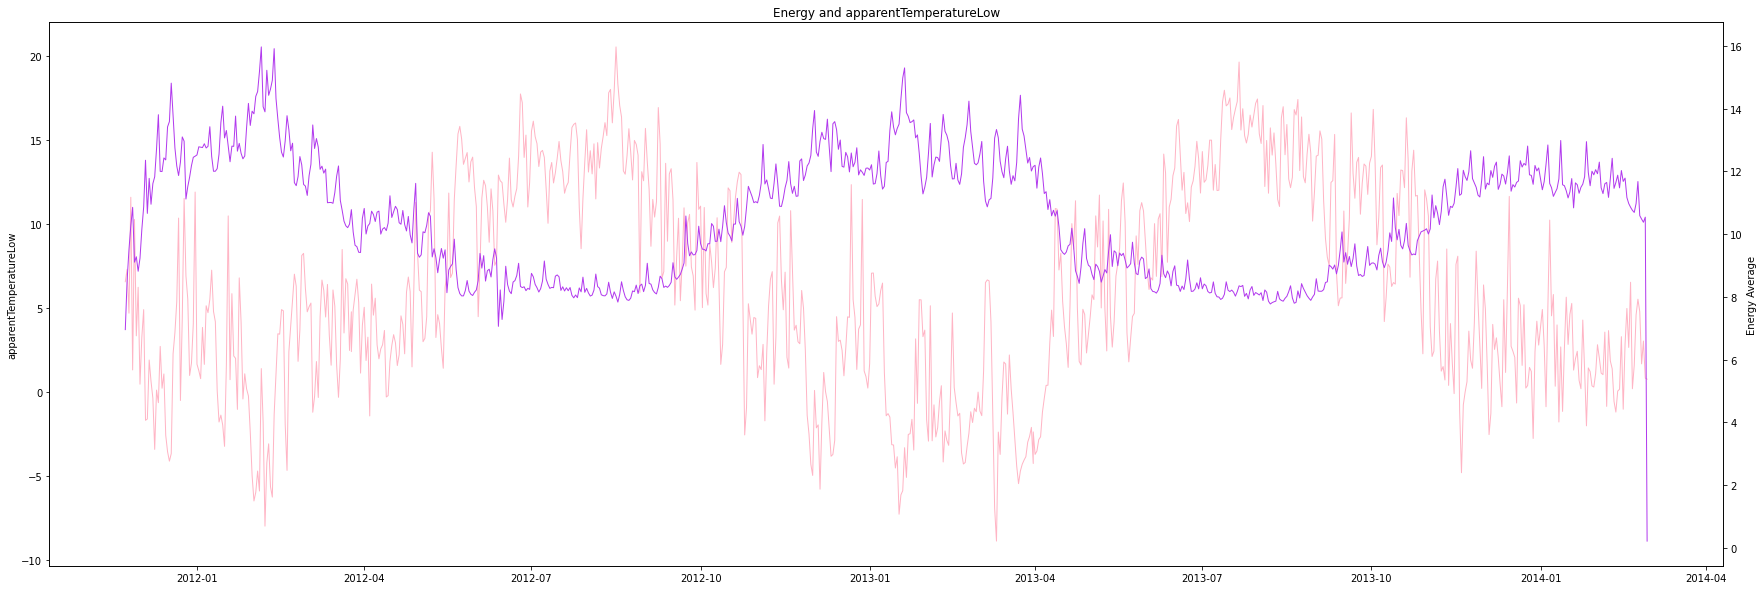

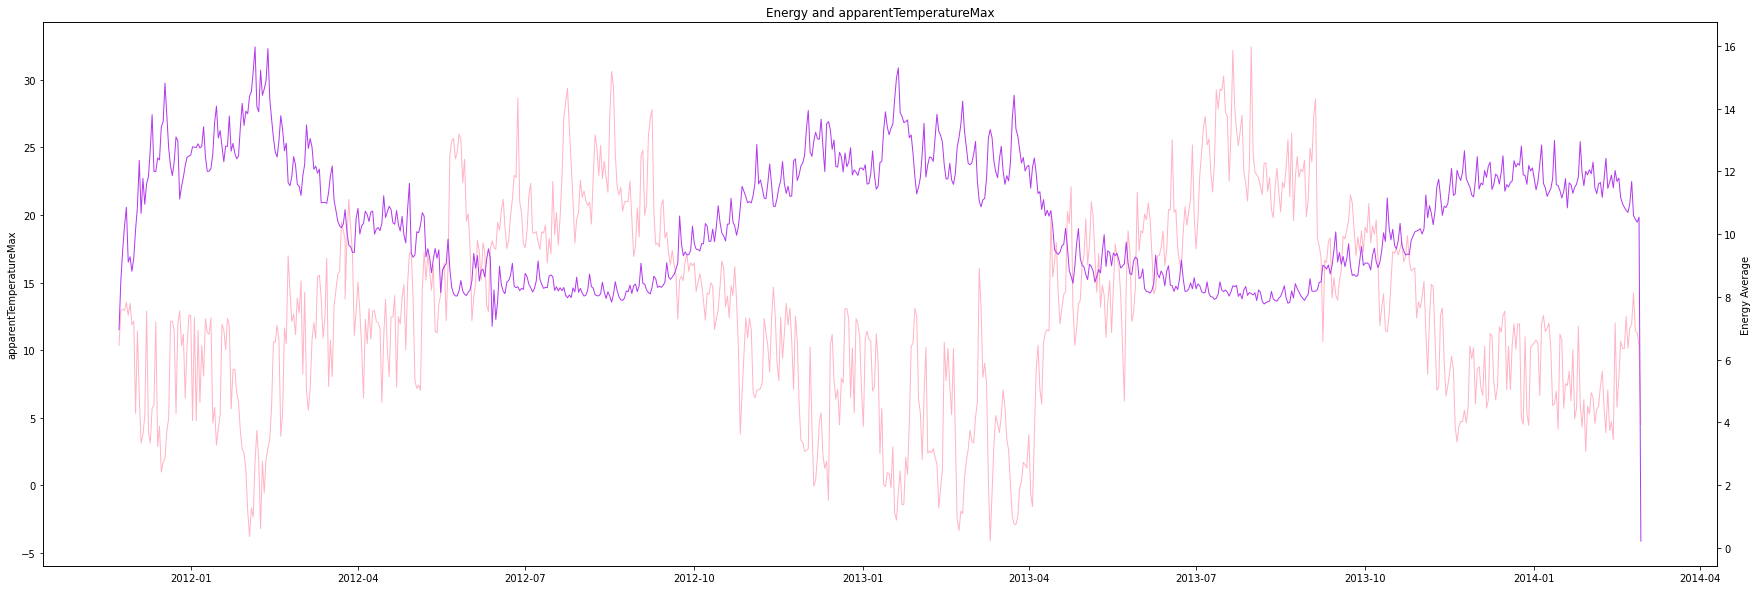

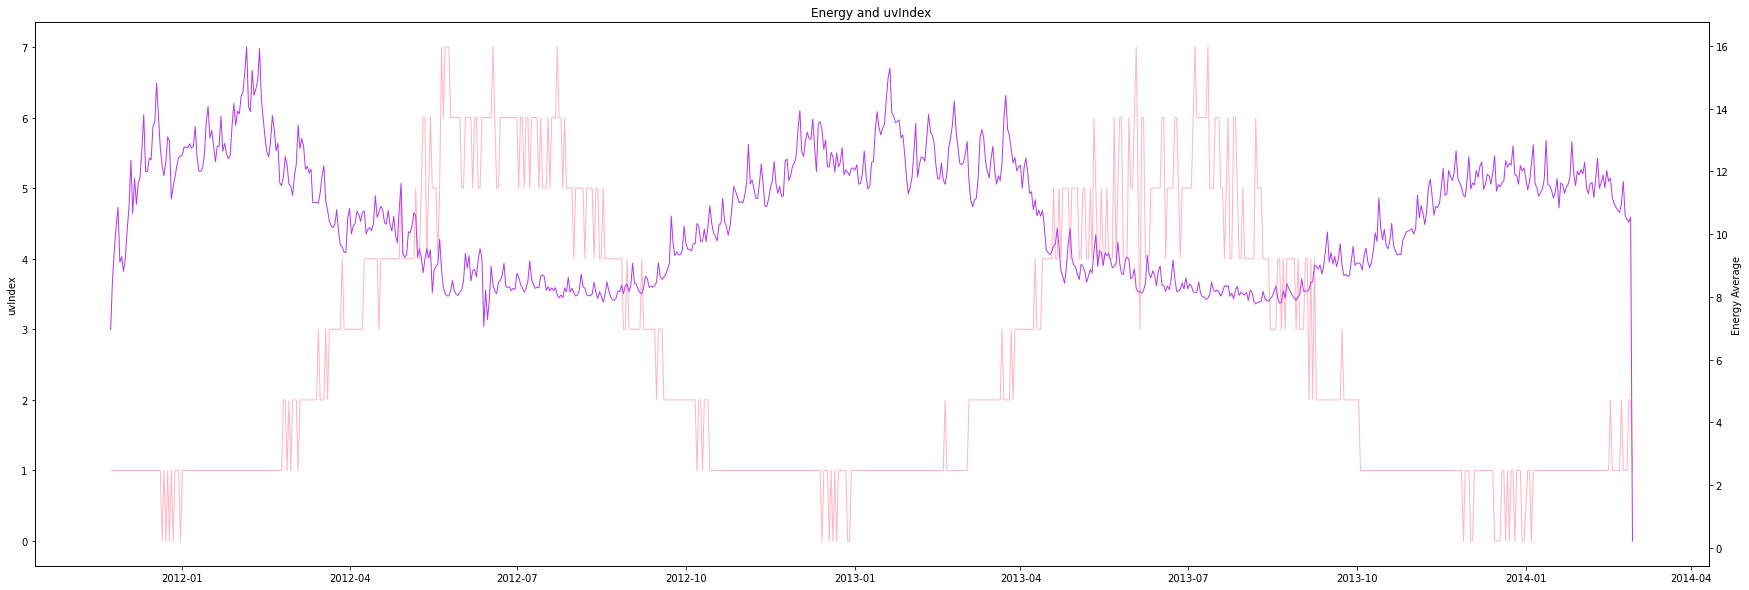

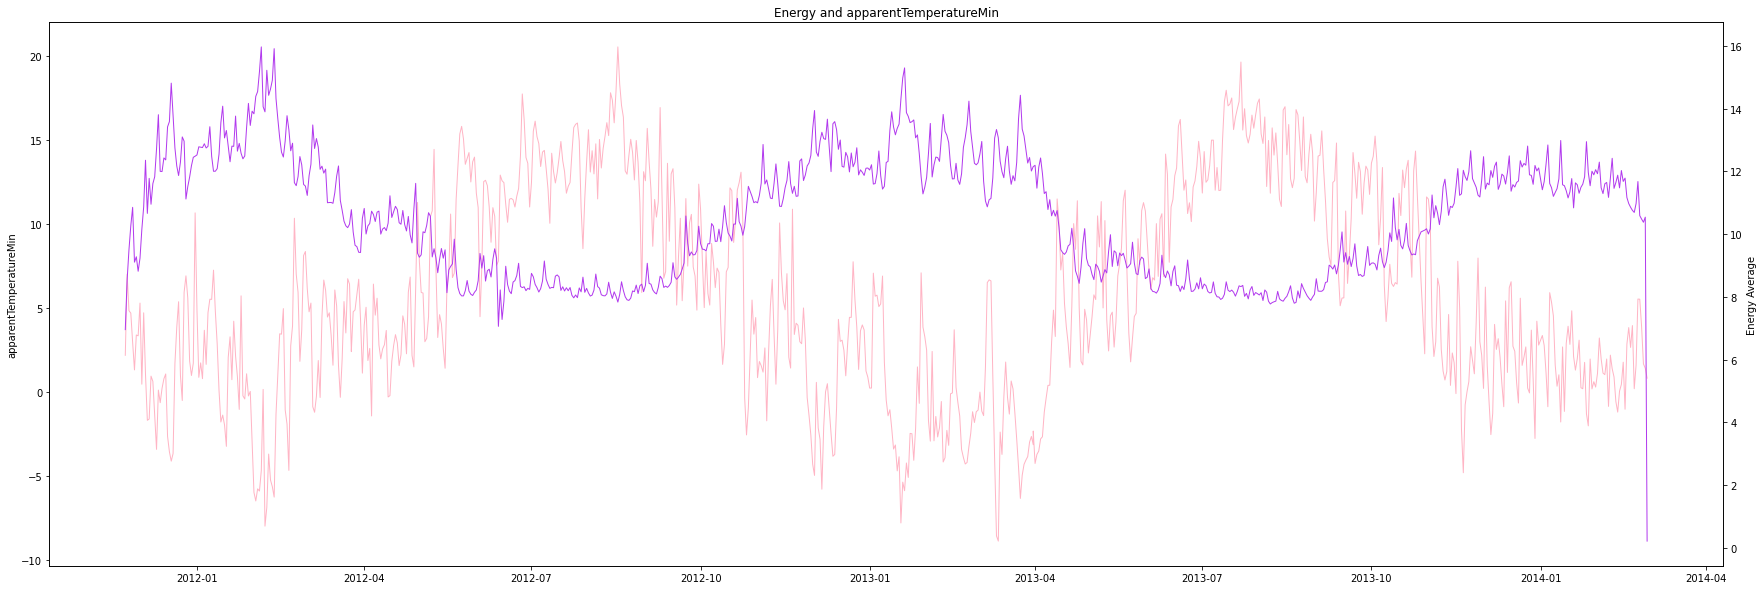

In [ ]:
for index in ['windBearing','dewPoint','cloudCover','windSpeed','pressure','apparentTemperatureHigh','visibility','humidity','apparentTemperatureLow','apparentTemperatureMax','uvIndex','apparentTemperatureMin']:
  fig,fig1 = plt.subplots(figsize=(30,10))
  
  fig1.plot(pddf['day'].to_numpy(),pddf[index].to_numpy(),color='#FFB5C5',lw=1)
  fig1.set_ylabel(str(index))

  fig2 = fig1.twinx()
  fig2.plot(pddf['day'].to_numpy(),pddf['energy_avg'].to_numpy(),color='#B23AEE',lw=1)
  fig2.set_ylabel('Energy Average')
  plt.title('Energy and ' + str(index))
  plt.show()
  plt.close()

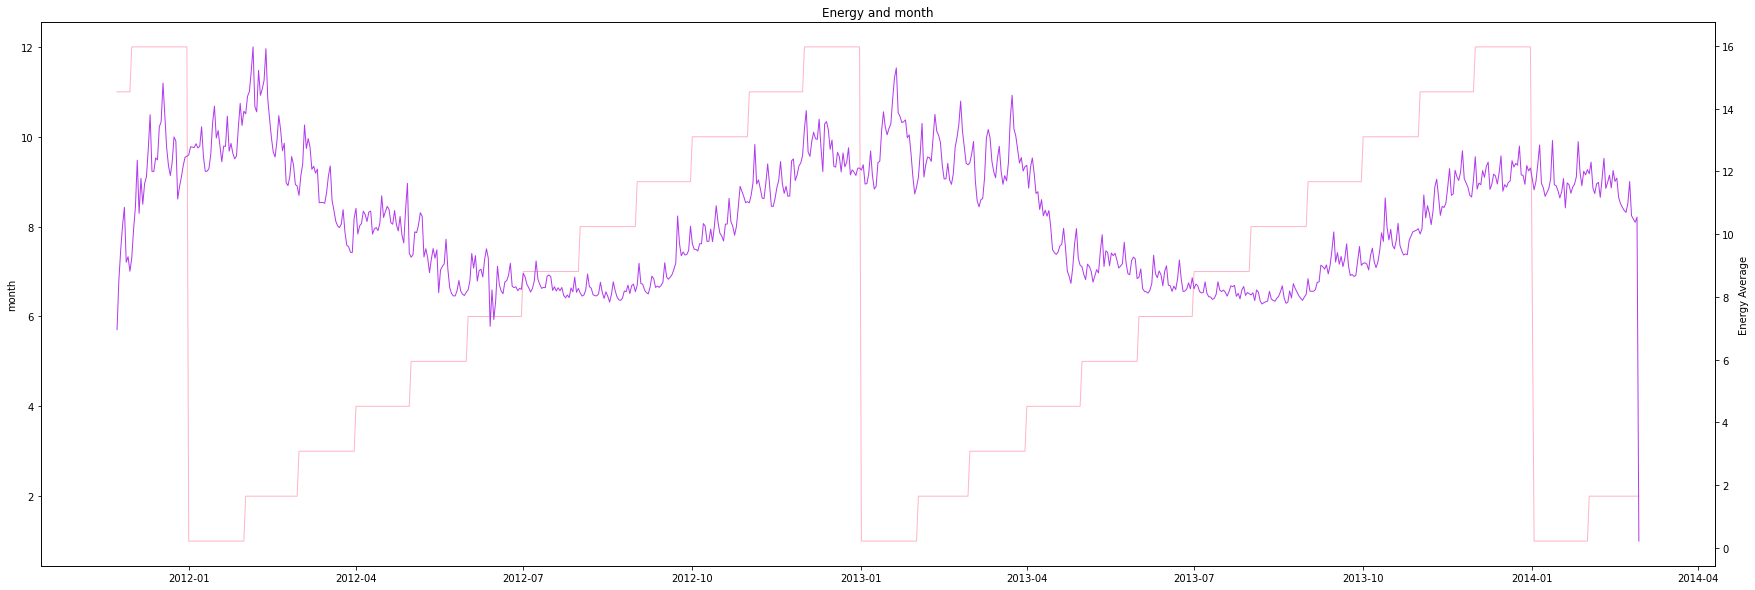

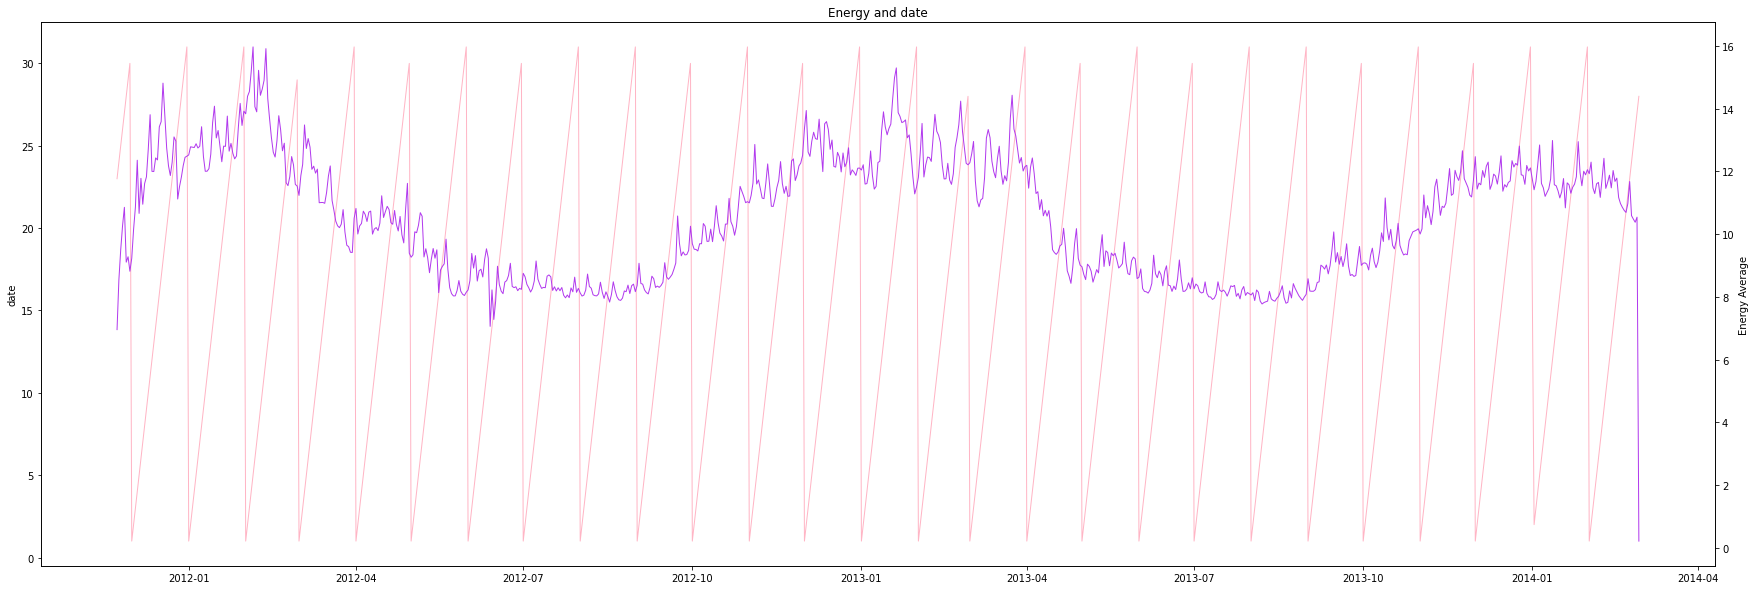

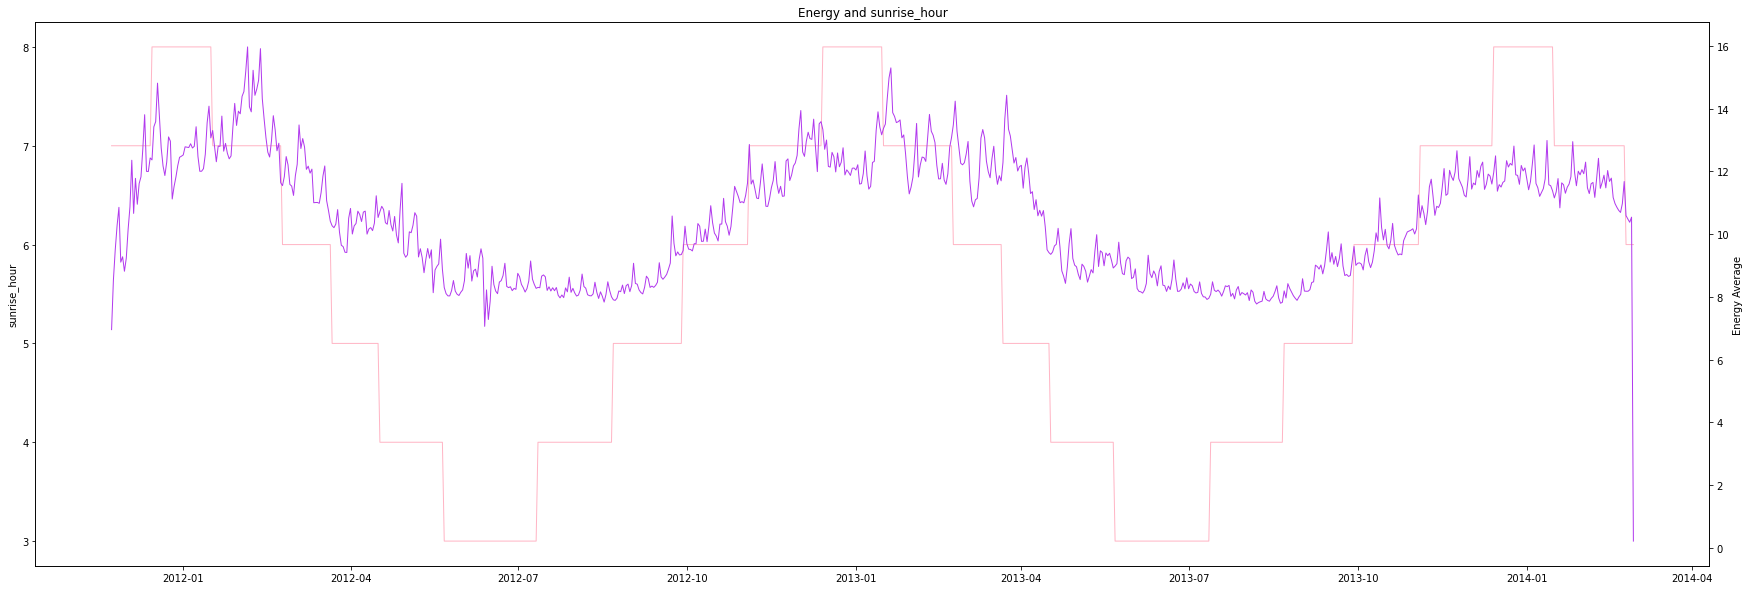

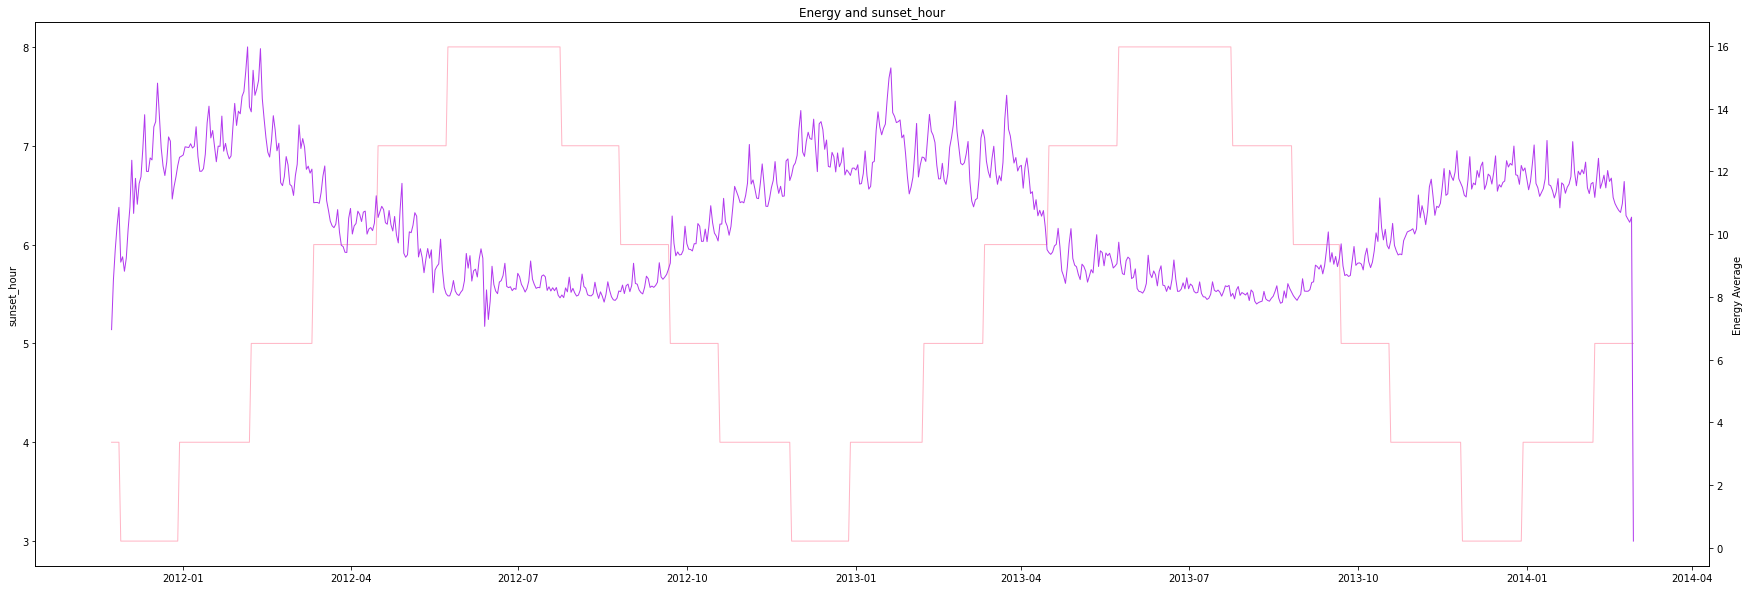

In [ ]:
for index in ['month','date','sunrise_hour','sunset_hour']:
  fig,fig1 = plt.subplots(figsize=(30,10))
  
  fig1.plot(pddf['day'].to_numpy(),pddf[index].to_numpy(),color='#FFB5C5',lw=1)
  fig1.set_ylabel(str(index))

  fig2 = fig1.twinx()
  fig2.plot(pddf['day'].to_numpy(),pddf['energy_avg'].to_numpy(),color='#B23AEE',lw=1)
  fig2.set_ylabel('Energy Average')
  plt.title('Energy and ' + str(index))
  plt.show()
  plt.close()

## **Data in Hist**

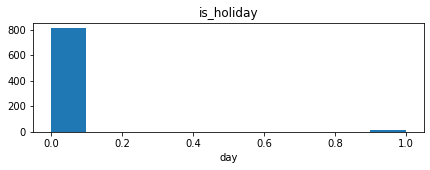

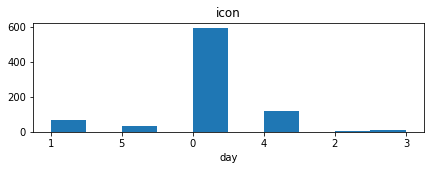

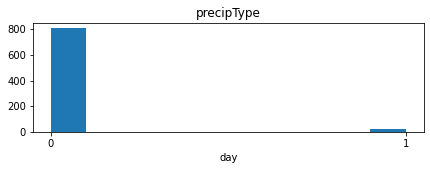

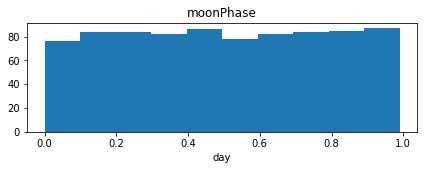

In [ ]:
for index in ['is_holiday','icon','precipType','moonPhase']:

  plt.figure(figsize=(7,2))
  plt.hist(pddf[index].to_numpy())

  plt.xlabel("day")
  plt.title(str(index))

  plt.show()
  plt.close()

I found that some of these features did not correlate well with the average of energy consumption or repeated with other features, so I removed them from training data.

In [ ]:
pddf = pddf.drop(['windBearing','windSpeed','pressure','visibility', 'temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','day'])

In [ ]:
pddf.astype('float64')

22/06/07 01:40:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


house_num  is_holiday  temperatureMax  icon  dewPoint  cloudCover  precipType  humidity  apparentTemperatureMax  uvIndex  temperatureMin  apparentTemperatureMin  moonPhase  energy_avg  month  date  sunrise_hour  sunset_hour
49        13.0         0.0           10.36   1.0      6.29        0.36         0.0      0.93                   10.36      1.0            3.81                    2.18       0.94    6.952692   11.0  23.0           7.0          4.0
29        25.0         0.0           12.93   5.0      8.56        0.41         0.0      0.89                   12.93      1.0            8.56                    7.01       0.97    8.536480   11.0  24.0           7.0          4.0
93        32.0         0.0           13.03   0.0      7.24        0.48         0.0      0.79                   13.03      1.0            7.46                    4.84       0.01    9.499781   11.0  25.0           7.0          4.0
20        41.0         0.0           12.96   4.0      6.96        0.44         0.0      0.81                   12.96      1.0            7.01                    4.69       0.05   10.267707   11.0  26.0           7.0          4.0
10        41.0         0.0           13.54   4.0      5.76        0.42         0.0      0.72                   13.54      1.0            4.47                    2.94       0.08   10.850805   11.0  27.0           7.0          4.0
72        55.0         0.0           12.58   5.0      4.39        0.56         0.0      0.86                   12.58      1.0            1.31                    1.31       0.12    9.103382   11.0  28.0           7.0          3.0
23        63.0         0.0           13.47   4.0      8.61        0.60         0.0      0.82                   13.47      1.0            6.37                    3.39       0.15    9.274873   11.0  29.0           7.0          3.0
57        76.0         0.0           11.87   4.0      5.26        0.31         0.0      0.78                   11.87      1.0            6.34                    3.34       0.19    8.813513   11.0  30.0           7.0          3.0
61        92.0         0.0           12.15   0.0      6.87        0.57         0.0      0.82                   12.15      1.0            6.08                    5.29       0.22    9.227707   12.0   1.0           7.0          3.0
75       100.0         0.0            8.07   4.0      3.69        0.32         0.0      0.87                    5.33      1.0            2.56                    0.46       0.25   10.145910   12.0   2.0           7.0          3.0
25       110.0         0.0           11.42   0.0      6.58        0.54         0.0      0.79                   11.42      1.0            8.12                    4.71       0.28   10.862155   12.0   3.0           7.0          3.0
94       110.0         0.0            9.11   0.0      4.87        0.36         0.0      0.82                    6.66      1.0            4.69                    1.03       0.31   12.351882   12.0   4.0           7.0          3.0
52       126.0         0.0            6.87   0.0      0.84        0.20         0.0      0.77                    3.13      1.0            2.81                   -1.69       0.34   10.657492   12.0   5.0           7.0          3.0
30       132.0         0.0            6.91   0.0      2.15        0.34         0.0      0.83                    3.77      1.0            2.68                   -1.61       0.37   11.774341   12.0   6.0           7.0          3.0
89       152.0         0.0            9.02   4.0      1.79        0.29         0.0      0.68                    5.14      1.0            4.91                    0.94       0.40   10.948980   12.0   7.0           7.0          3.0
86       167.0         0.0           12.89   4.0      5.96        0.53         0.0      0.81                   12.89      1.0            4.27                    0.63       0.43   11.606970   12.0   8.0           7.0          3.0
54       184.0         0.0            7.68   0.0      0.41        0.15         0.0      0.71                    

In [ ]:
pddf.info()

22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 828 entries, 49 to 732
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   house_num               828 non-null    int64  
 1   is_holiday              828 non-null    int64  
 2   temperatureMax          828 non-null    float64
 3   icon                    828 non-null    object 
 4   dewPoint                828 non-null    float64
 5   cloudCover              828 non-null    float64
 6   precipType              828 non-null    object 
 7   humidity                828 non-null    float64
 8   apparentTemperatureMax  828 non-null    float64
 9   uvIndex                 828 non-null    float64
 10  temperatureMin          828 non-null    float64
 11  apparentTemperatureMin  828 non-null    float64
 12  moonPhase               828 non-null    float64
 13  energy_avg              828 non-null    float64
 14  month                   828 non-null  

22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# **Data Scaling**

Data scaling and standardization

In [ ]:
df_train = pddf.drop('energy_avg',axis=1)

In [ ]:
min_max_scaler=preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(df_train.to_numpy())  #scaling makes the search jumps smoother in the gradient decent 

df_temp = df_train.to_numpy()
df_sts = min_max_scaler.transform(df_temp)
df_sts = preprocessing.normalize(df_sts,norm="l2") # normalization can accelerate the convergence and makes different features are numerically comparable   
df_sts = pd.DataFrame(df_sts) # transform the data into DataFrame

scaler = StandardScaler()
df_tempSS = scaler.fit_transform(df_sts)
df_X = pd.DataFrame(df_tempSS)
# df_X.columns = pddf.columns
df_X.head()


22/06/07 01:40:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0         1         2         3         4         5         6   \
0 -2.293706 -0.003800 -0.545251  0.092595 -0.079209 -0.606004 -0.006155   
1 -2.251805  0.072383 -0.113547  2.398894  0.367051 -0.338395  0.069451   
2 -2.280831  0.001845 -0.108933 -0.490117  0.114060  0.010009 -0.000552   
3 -2.345915 -0.149438 -0.145114  1.888504  0.076254 -0.209485 -0.150690   
4 -2.357136 -0.173713 -0.049477  1.895174 -0.178854 -0.319921 -0.174781   

         7         8         9         10        11        12        13  \
0  1.529519 -0.378410 -0.851529 -0.757019 -0.602514  1.476590  1.252327   
1  1.069424 -0.011091 -0.819594  0.204006  0.182827  1.539359  1.223461   
2  0.077574 -0.000806 -0.849163 -0.014413 -0.167187 -1.646461  1.250188   
3  0.335911 -0.018677 -0.912578 -0.110044 -0.200504 -1.583071  1.307510   
4 -0.637801  0.066365 -0.922754 -0.654981 -0.503352 -1.488236  1.316708   

         14        15        16  
0  0.794109  0.900852 -0.935475  
1  0.883755  0.878518 -0.913417  
2  1.013901  0.899197 -0.933841  
3  1.176933  0.943549 -0.977644  
4  1.302017  0.950665 -0.984673

# **Feature Selecting**

Use random forest on the dataset, analyze the feature importance, and select 10 of these features as the training set.

In [ ]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       828 non-null    float64
 1   1       828 non-null    float64
 2   2       828 non-null    float64
 3   3       828 non-null    float64
 4   4       828 non-null    float64
 5   5       828 non-null    float64
 6   6       828 non-null    float64
 7   7       828 non-null    float64
 8   8       828 non-null    float64
 9   9       828 non-null    float64
 10  10      828 non-null    float64
 11  11      828 non-null    float64
 12  12      828 non-null    float64
 13  13      828 non-null    float64
 14  14      828 non-null    float64
 15  15      828 non-null    float64
 16  16      828 non-null    float64
dtypes: float64(17)
memory usage: 110.1 KB


In [ ]:
df_y = pddf['energy_avg']

In [ ]:
df_y = pd.DataFrame(df_y.to_numpy())

22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/07 01:40:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
X_FE = df_X.to_numpy()
y_train = df_y.to_numpy()

/var/folders/kp/jkfp6kxs3dlgw9gmzx7570ch0000gn/T/ipykernel_825/3241989238.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr_rf = clf_rf.fit(X_FE,y_train)
/var/folders/kp/jkfp6kxs3dlgw9gmzx7570ch0000gn/T/ipykernel_825/3241989238.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr_rf_5 = clf_rf_5.fit(X_FE,y_train)


Feature ranking:
1. feature 8 (0.476368)
2. feature 15 (0.191298)
3. feature 2 (0.134120)
4. feature 13 (0.042593)
5. feature 0 (0.039697)
6. feature 6 (0.023554)
7. feature 11 (0.021788)
8. feature 9 (0.010422)
9. feature 12 (0.009314)
10. feature 3 (0.008869)
11. feature 16 (0.008829)
12. feature 10 (0.006604)
13. feature 1 (0.005805)
14. feature 4 (0.005538)
15. feature 14 (0.005520)
16. feature 7 (0.004912)
17. feature 5 (0.004769)


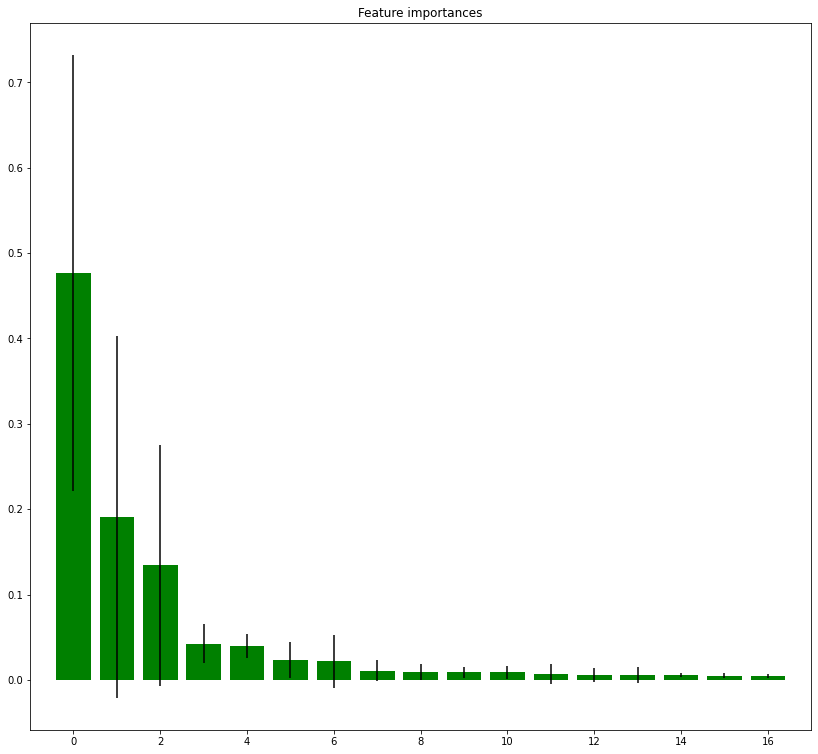

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(random_state=43)      
clr_rf = clf_rf.fit(X_FE,y_train)

clf_rf_5 = RandomForestRegressor()      
clr_rf_5 = clf_rf_5.fit(X_FE,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_FE.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_FE.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xlim([-1, X_FE.shape[1]])
plt.show()


In [ ]:
df1 = pd.DataFrame(X_FE)

In [ ]:
# select the most important 20 features
df_X_10 = pd.DataFrame()
for k in range(10):
  df_X_10[k] = df_X.iloc[:,indices[k]]
df_X_10

0         1         2         3         4         5         6  \
0   -0.378410  0.900852 -0.545251  1.252327 -2.293706 -0.006155 -0.602514   
1   -0.011091  0.878518 -0.113547  1.223461 -2.251805  0.069451  0.182827   
2   -0.000806  0.899197 -0.108933  1.250188 -2.280831 -0.000552 -0.167187   
3   -0.018677  0.943549 -0.145114  1.307510 -2.345915 -0.150690 -0.200504   
4    0.066365  0.950665 -0.049477  1.316708 -2.357136 -0.174781 -0.503352   
..        ...       ...       ...       ...       ...       ...       ...   
823  0.170729  0.342140  0.019225 -1.423944  0.647302 -0.673967 -0.066938   
824 -0.266096  0.307920 -0.448838 -1.291261  0.516729 -0.326448 -0.354894   
825 -0.282484  0.303759 -0.463371 -1.275129  0.499599 -0.284194 -0.745581   
826 -0.425085  0.299142 -0.623066 -1.257225  0.480170 -0.237300 -0.781142   
827 -1.174312  0.269322 -1.003591 -1.141601  0.364490  0.065538 -0.806415   

            7         8         9  
0   -0.851529  1.476590  0.092595  
1   -0.819594  1.539359  2.398894  
2   -0.849163 -1.646461 -0.490117  
3   -0.912578 -1.583071  1.888504  
4   -0.922754 -1.488236  1.895174  
..        ...       ...       ...  
823 -1.133602  1.303309  2.033387  
824 -0.986816  1.331616 -0.640505  
825 -0.386257  1.461506 -0.621006  
826 -0.374372  1.549561 -0.599367  
827 -0.821247  1.541329 -0.459620  

[828 rows x 10 columns]

# **Data Spliting**

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_X_10, df_y, test_size = 0.3, random_state = 1) # split the dataset

# SARIMAX

In [ ]:
test_df = pd.DataFrame()
test_df['day'] = new_df['day']
test_df['energy_avg'] = new_df['energy_avg']
test_df['temperature_max'] = new_df['apparentTemperatureMax']
test_df.set_index(['day'],inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 828 entries, 2011-11-23 to 2014-02-28
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   energy_avg       828 non-null    float64
 1   temperature_max  828 non-null    float64
dtypes: float64(2)
memory usage: 19.4+ KB


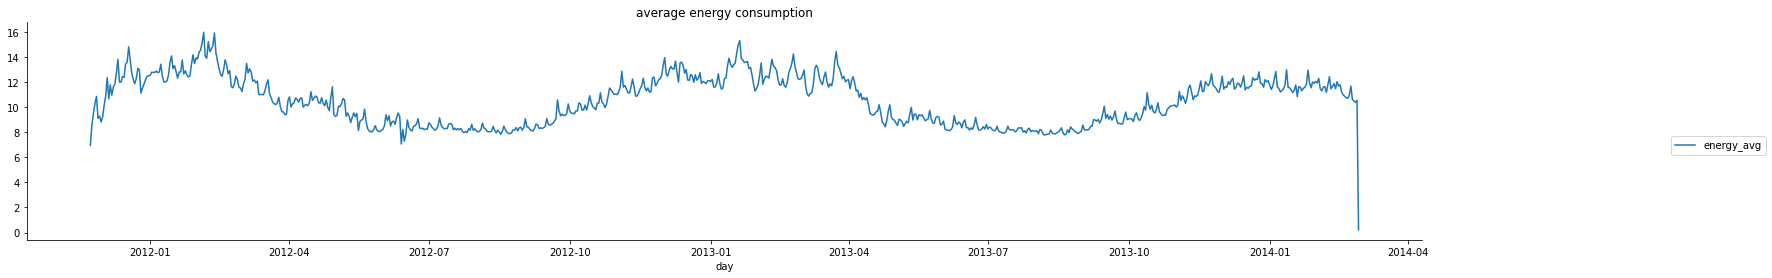

In [ ]:
# Data overview
test_df['energy_avg'].plot(figsize=(25,4))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title('average energy consumption')
sns.despine()
plt.show()

<AxesSubplot:xlabel='day'>

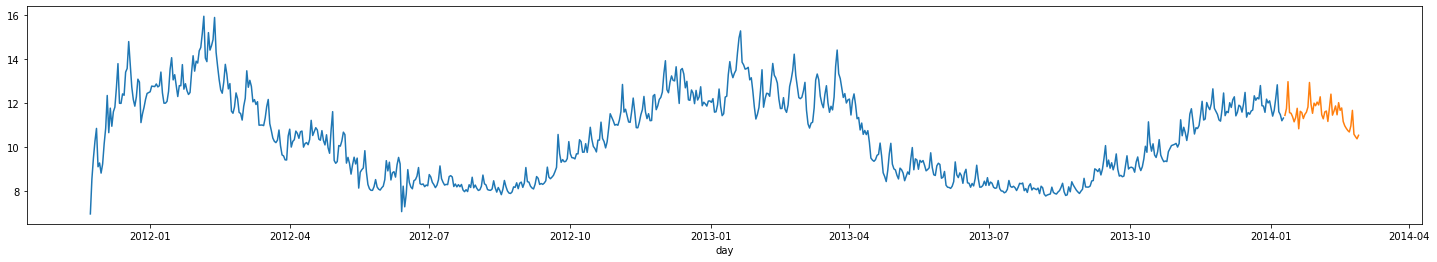

In [ ]:
# Split data and display
train = test_df.iloc[0:(len(test_df)-50)]
test = test_df.iloc[len(train):(len(test_df)-1)]

train['energy_avg'].plot(figsize=(25,4))
test['energy_avg'].plot(figsize=(25,4))

In [ ]:
print(sm.tsa.adfuller(train.energy_avg,regression='c'))

print(sm.tsa.adfuller(train.energy_avg,regression='nc'))

print(sm.tsa.adfuller(train.energy_avg,regression='ct'))

(-1.9136428904002345, 0.3256705332774045, 21, 756, {'1%': -3.439029421541435, '5%': -2.8653706489231876, '10%': -2.568809835460933}, 836.5778403773566)
(-0.5166949980037926, 0.48924937383576345, 21, 756, {'1%': -2.5687037534643484, '5%': -1.9413611063865364, '10%': -1.616473367154012}, 838.1096082328875)
(-1.741085415937822, 0.7324496857345786, 21, 756, {'1%': -3.970795050134556, '5%': -3.416313322447787, '10%': -3.1304770250748417}, 838.3407726320461)


/Users/gengyifan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [ ]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [ ]:
print(sm.tsa.adfuller(difference(train.energy_avg,1),regression='c'))

print(sm.tsa.adfuller(difference(train.energy_avg,1),regression='nc'))

print(sm.tsa.adfuller(difference(train.energy_avg,1),regression='ct'))

(-6.627235541075873, 5.834673267922872e-09, 20, 756, {'1%': -3.439029421541435, '5%': -2.8653706489231876, '10%': -2.568809835460933}, 838.2727387834509)
(-6.640161844732689, 3.825911302220866e-10, 20, 756, {'1%': -2.5687037534643484, '5%': -1.9413611063865364, '10%': -1.616473367154012}, 836.3099981341729)
(-6.677154168329638, 7.491076673660423e-08, 20, 756, {'1%': -3.970795050134556, '5%': -3.416313322447787, '10%': -3.1304770250748417}, 839.4088594672974)


/Users/gengyifan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


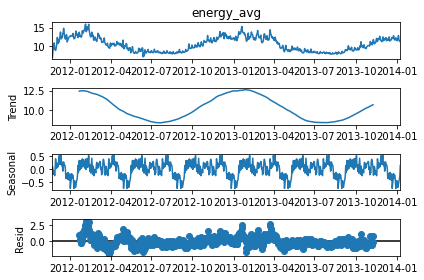

<Figure size 3600x720 with 0 Axes>

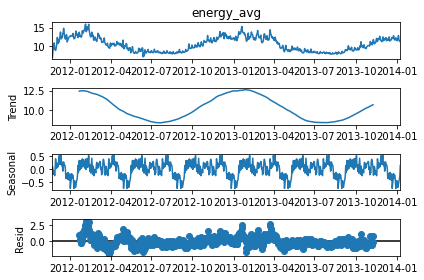

In [ ]:
# Seasonal Decomposition
decomposition = seasonal_decompose(train['energy_avg'],period=120)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
plt.figure(figsize=[50, 10])
decomposition.plot()


/Users/gengyifan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


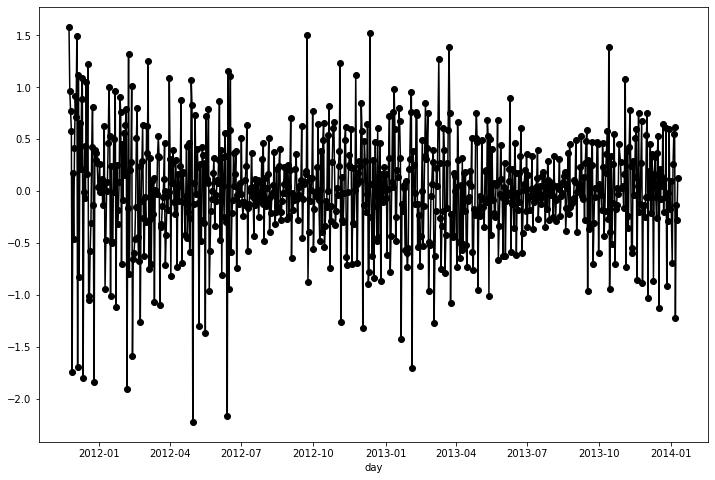

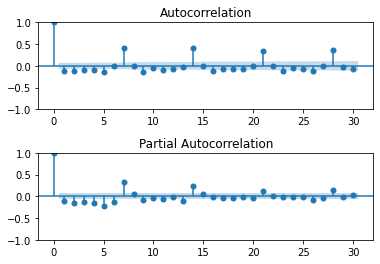

In [ ]:
# Draw ACF and PACF plots to determine p, q values
diff=train['energy_avg'].diff(1)
diff.dropna(inplace=True)
diff.plot(figsize=(12,8),marker='o',color='black')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)  
    plt.subplots_adjust(hspace=0.5)
    plt.show()
draw_acf_pacf(diff,30)

In [ ]:
# Seasonal_order is ordered by grid search, seasonal_order=0,2,0,12 is better
def get_ARIMA_params(data, pdq, m):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
pdq = [0, 1, 1]
get_ARIMA_params(train['energy_avg'], pdq, m=12)

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37259D-01    |proj g|=  1.61530D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   8.541D-06   7.370D-01
  F =  0.73702291073873338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(0, 0, 0, 12)12 - AIC:1150.8076491094691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.830D-05   6.640D-01
  F =  0.66402893008987818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 0, 2, 12)12 - AIC:1041.2290152198505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10194D+00    |proj g|=  1.97248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauc

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69485D-01    |proj g|=  5.86379D-01

At iterate    5    f=  7.30366D-01    |proj g|=  4.75273D-02

At iterate   10    f=  7.29285D-01    |proj g|=  1.33354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   1.632D-05   7.293D-01
  F =  0.72928452062135485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 1, 1, 12)12 - AIC:1140.7667140868282
RUNNING THE L-BFGS-B CODE

 

 This problem is unconstrained.



At iterate    5    f=  6.87982D-01    |proj g|=  5.87892D-02

At iterate   10    f=  6.87398D-01    |proj g|=  1.45931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   1.682D-05   6.874D-01
  F =  0.68739812000305767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 1, 2, 12)12 - AIC:1077.5914747247577
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61365D+00    |proj g|=  4.78870D-02

           * * *

Tit   = t

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40034D+00    |proj g|=  6.53080D-01


 This problem is unconstrained.



At iterate    5    f=  1.08239D+00    |proj g|=  4.52430D-02

At iterate   10    f=  1.08176D+00    |proj g|=  3.08482D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   6.877D-07   1.082D+00
  F =   1.0817649315023892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(0, 2, 1, 12)12 - AIC:1689.2262334177176
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21738D+00    |proj g|=  5.46223D-01


 This problem is unconstrained.



At iterate    5    f=  8.29403D-01    |proj g|=  3.93845D-01

At iterate   10    f=  7.51813D-01    |proj g|=  6.41829D-01

At iterate   15    f=  7.50081D-01    |proj g|=  3.76383D-03

At iterate   20    f=  7.50074D-01    |proj g|=  2.52890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   4.284D-04   7.501D-01
  F =  0.75007396364120649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 2, 2, 12)12 - AIC:1175.1150874257173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 va

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.02282D-01    |proj g|=  6.88039D-02

At iterate   10    f=  6.91834D-01    |proj g|=  5.46530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   2.307D-07   6.918D-01
  F =  0.69179406119554809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(1, 0, 1, 12)12 - AIC:1084.431559220273
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74462D-01    |proj g|=  1.45406D-01


 This problem is unconstrained.



At iterate    5    f=  6.61491D-01    |proj g|=  1.08713D-02

At iterate   10    f=  6.61366D-01    |proj g|=  1.07337D-03

At iterate   15    f=  6.61359D-01    |proj g|=  2.05172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   2.125D-06   6.614D-01
  F =  0.66135898427583384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(1, 0, 2, 12)12 - AIC:1039.0745795331975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56

 This problem is unconstrained.



At iterate    5    f=  9.33088D-01    |proj g|=  8.30380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   6.372D-06   9.331D-01
  F =  0.93307393055025400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(1, 1, 0, 12)12 - AIC:1457.8630359361953
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04479D-01    |proj g|=  4.88437D-01


 This problem is unconstrained.



At iterate    5    f=  7.24938D-01    |proj g|=  5.18161D-02

At iterate   10    f=  7.24529D-01    |proj g|=  2.20553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   4.852D-06   7.245D-01
  F =  0.72452863156036307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(1, 1, 1, 12)12 - AIC:1135.366550707925
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29413D-01    |proj g|=  6.50233D-01


 This problem is unconstrained.



At iterate    5    f=  6.94785D-01    |proj g|=  3.27339D-02

At iterate   10    f=  6.92939D-01    |proj g|=  2.05559D-02


In [ ]:
# train
mod = sm.tsa.statespace.SARIMAX(train.energy_avg,
                                exog=sm.add_constant(train.temperature_max),
                                order=(8, 0, 1),
                                seasonal_order=(0, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(10, 10))
plt.show()

In [ ]:
train['energy_avg'].plot(figsize=(25,4))
results.fittedvalues.plot()
plt.show()

In [ ]:
predict = results.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test['temperature_max']))
test['predicted'] = predict.values
test['diff'] = abs(test['energy_avg']-test['predicted'])
test.head()

In [ ]:
test['energy_avg'].plot(figsize=(25,5),color='blue')
test['predicted'].plot(figsize=(25,5),color='red')
plt.show()

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
 
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100


print('mae:', mean_absolute_error(test.energy_avg, test.predicted))
print('mse:', mean_squared_error(test.energy_avg, test.predicted))
print('mape:',mape(test.energy_avg, test.predicted))
print('smape:',smape(test.energy_avg, test.predicted))

# **Model training**

## **Decision Tree**

In [ ]:
# The decision tree algorithm is a method of approximating the value of a discrete function. It is a typical classification method that first processes 
# the data, uses an inductive algorithm to generate readable rules and decision trees, and then uses the decisions to analyze the new data. Essentially 
# a decision tree is the process of classifying data through a series of rules.
dt = tree.DecisionTreeRegressor() # Define the decision tree model
dt_param = [{"max_depth": [10, 20,30,40,50,60,70,80,90,100],    # Set the scope of grid search parameters to do the cross-validation
             "splitter": ["random"],    # dataset is large, so just choose "random"
             "min_samples_leaf": [1,2,3,4,5], 
             "min_samples_split": [1,2,3,4,5],
             "max_features": [1,2,3,4,5,6,7,8,9],
             "criterion": ["mae","mse"]}] 
dt_tun = RandomizedSearchCV(dt, dt_param) # Using RandomizedSearchCV to do the cross-validation while we can control the amount of the computing

dt_tun.fit(X_train,y_train) # training
print()
print("the Best parameter is：")
print(dt_tun.best_params_)

dt_predict = dt_tun.predict(X_test)

In [ ]:
# evaluation                 
print('r2_score', r2_score(y_test, dt_predict))
print('mae:', mean_absolute_error(y_test, dt_predict))
print('mse:', mean_squared_error(y_test, dt_predict))

## **SVM Regression**

In [ ]:
# SVR
# Support Vector Machine is a class of linear classifier which classifies data according to supervised learning. It creats a margin between two classes which separate the two classes totally
# generly, SVM has good learning ability and require little computer memory. 

svr = SVR() # define the training model

svr_param = [{'kernel': ['rbf'],  # set the scope of grid search parameters
              'gamma': [1e-3, 1e-4],
              'C': [0.1, 1, 10]},
             {'kernel': ['linear'], 
              'C': [0.1, 1, 10]}]
              
svr_tun = RandomizedSearchCV(svr, svr_param)
svr_tun.fit(X_train, y_train)
print("Best parameters:")
print()
print(svr_tun.best_params_)
svr_predict=svr_tun.predict(X_test) # show the best parameter

In [ ]:
# evaluation                 
print('r2_score', r2_score(y_test, svr_predict))
print('mae:', mean_absolute_error(y_test, svr_predict))
print('mse:', mean_squared_error(y_test, svr_predict))

## **Random Forest Regression**

In [ ]:
# Random Forest
# For the random forest, as long as there are enough trees in the random forest, the model will not overfit.

rf = RandomForestRegressor()
rf_param = { 'criterion': ['mse', 'mae'],
            'max_depth': [10,20,30,40,50,60,70,80,90,100],
            'max_features': ['auto', 'sqrt','log2', None],
            'min_samples_leaf': [1,2,3,4,5],
            'min_samples_split': [1,2,3,4,5],
            'n_estimators': [10,20,30]} 

rf_tun = RandomizedSearchCV(rf, rf_param)
rf_tun = rf_tun.fit(X_train, y_train)
print("Best parameters:")
print()
print(rf_tun.best_params_)
rf_predict=rf_tun.predict(X_test) # show the best parameter

In [ ]:
# evaluation                 
print('r2_score', r2_score(y_test, rf_predict))
print('mae:', mean_absolute_error(y_test, rf_predict))
print('mse:', mean_squared_error(y_test, rf_predict))

## **MLPN**

In [ ]:
# MLPN
# MLPN is sensitive to scaling, adding scaling can improve model accuracy and GD convergence speed to a certain extent
mlp = MLPRegressor(solver='adam', random_state=1,max_iter=10000)       #Solver chose ADAM because ADAM works well on a relatively large data sets, and max_iter must be large enough to converge. So I set it 10000
mlp_parameter_dict =[{'learning_rate': ["constant", "invscaling", "adaptive"],
                    'hidden_layer_sizes': [(10), (20), (30)],
                    'alpha': [10**-1, 10**-7],
                    'activation': ["relu", "tanh"]}]
mlp_tun=RandomizedSearchCV(mlp, mlp_parameter_dict)
mlp_tun= mlp_tun.fit(X_train, y_train)
print("Best parameters:")
print()
print(mlp_tun.best_params_)
MLPR_predict = mlp_tun.predict(X_test)

In [ ]:
# evaluation                 
print('r2_score', r2_score(y_test, MLPR_predict))
print('mae:', mean_absolute_error(y_test, MLPR_predict))
print('mse:', mean_squared_error(y_test, MLPR_predict))